In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing.data import QuantileTransformer

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#  VARIABLES

- **ID**  : Identificador
- **MORA60**  : Indicador mora>60 días en el transcurso de un año luego de haberle otorgado el crédito
 (0:No tuvo mora 60, 1:Sí tuvo mora 60).
- **VAR01**  : Número de días de atraso máximo durante los 12 meses antes de la aprobación del crédito.
- **VAR02**  : Situación de la casa. (ALQUILADA,FAMILIAR,OTRAS,PROPIA)
- **VAR03**  : Edad 
- **VAR04**  : Fecha ingreso al empleo.
- **VAR05**  : Máxima antigüedad con Tarjeta de crédito en el Sistema Financiero (en meses).
- **VAR06**  : Número de meses con algún producto Pasivo (ahorro) durante los 12 meses antes de la aprobación del crédito.
- **VAR07**  : Ingreso mensual.
- **VAR08**  : Monto de Línea de crédito Tarjeta de Crédito en el Sistema Financiero.
- **VAR09**  : Monto de Saldo deudor promedio total en el Sistema Financiero.
- **VAR10**  : Score con el que fue aprobada la Tarjeta de crédito en el Banco.
- **VAR11**  : Número de veces con Abono de Pago de Haberes en el Banco durante los 12 meses antes de la aprobación del crédito.
- **VAR12**  : Zona geográfica.
- **VAR13**  : Máxima clasificación de Riesgos SBS  durante los 12 meses antes de la aprobación del crédito (0: Normal, 1:CPP,
2:Deficiente, 3:Dudoso, 4:Pérdida).
- **VAR14**  : Nivel educativo.

In [742]:
ren_columns = ['MORA60','DAT', 'SC', 'AGE', 'FIE', 'ATC', 
               'MPP', 'IGM', 'MLC', 'MSD', 'SCORE', 
               'PHA', 'ZONA', 'RSBS', 'NED']
df = pd.read_excel('caso_TC.XLSX')
df.drop('ID', axis=1, inplace=True)
df.columns = ren_columns
df.head()

,MORA60,DAT,SC,AGE,FIE,ATC,MPP,IGM,MLC,MSD,SCORE,PHA,ZONA,RSBS,NED
0,0,235,FAMILIAR,30,2007-06-01,93,5,3500.0,0.00,0.00,214,5,Lima,4,PROFESIONAL
1,0,18,FAMILIAR,32,2005-02-01,9,12,900.0,1824.67,1933.75,175,12,La Libertad,1,TECNICO
2,0,0,FAMILIAR,26,2003-08-01,8,2,2400.0,2797.38,188.29,187,0,Lima,0,PROFESIONAL
3,0,0,FAMILIAR,36,2003-07-01,20,12,2700.0,0.00,0.00,187,12,Ancash,0,TECNICO
4,0,0,FAMILIAR,46,2006-11-01,0,1,3100.0,2000.00,11010.65,189,0,Lima,0,TECNICO


In [552]:
df.describe()

,MORA60,DAT,AGE,ATC,MPP,IGM,MLC,MSD,SCORE,PHA,RSBS
count,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,0.700,4.481,36.429,25.386,10.571,4373.572,10236.736,5732.438,196.762,7.901,0.564
std,0.458,13.945,9.787,32.014,3.396,5393.520,19853.871,10869.692,19.416,5.278,0.903
min,0.000,0.000,20.000,0.000,0.000,123.700,0.000,0.000,134.000,0.000,0.000
25%,0.000,0.000,29.000,0.000,12.000,1400.000,389.365,283.605,182.000,0.000,0.000
50%,1.000,0.000,34.000,12.000,12.000,2400.000,2915.955,2077.105,197.000,12.000,0.000
75%,1.000,2.000,42.000,39.000,12.000,4900.000,9763.388,5384.220,212.000,12.000,1.000
max,1.000,245.000,85.000,130.000,12.000,30000.000,121543.400,57094.380,266.000,12.000,4.000


In [553]:
numerics = []
for cl in df.columns:
    if df[cl].dtype in ['int64', 'float64'] and cl !='MORA60':
        numerics.append(cl)
numerics

['DAT', 'AGE', 'ATC', 'MPP', 'IGM', 'MLC', 'MSD', 'SCORE', 'PHA', 'RSBS']

## Working w categorical variables (ord, nom)

In [554]:
ndf = df
ndf['SC'] = ndf['SC'].apply(lambda x: x if x  in ['FAMILIAR'] else 'OTRAS')
ndf = ndf.join(pd.get_dummies(ndf['SC'], prefix='SC', prefix_sep='_'))
ndf.drop('SC_OTRAS', inplace=True, axis=1)

In [555]:
ndf['ZONA'] = ndf['ZONA'].apply(lambda x: x.upper() if x  in ['Lima'] else 'OTRAS')
ndf = ndf.join(pd.get_dummies(ndf['ZONA'], prefix='ZONA', prefix_sep='_'))
ndf.drop('ZONA_OTRAS', inplace=True, axis=1)

In [556]:
ndf['NED'] = ndf['NED'].apply(lambda x: x if x  in ['PROFESIONAL'] else 'OTRAS')
ndf = ndf.join(pd.get_dummies(ndf['NED'], prefix='NED', prefix_sep='_'))
ndf.drop('NED_OTRAS', inplace=True, axis=1)

In [557]:
ndf['RSBS'] = df['RSBS'].map(dict([(0, 'NORM'),
                                         (1, 'OTRO'),
                                         (2, 'OTRO'),
                                         (3, 'OTRO'),
                                         (4, 'OTRO')]))
ndf = ndf.join(pd.get_dummies(ndf['RSBS'], prefix='RSBS', prefix_sep='_'))
ndf.drop('RSBS_OTRO', inplace=True, axis=1)

In [558]:
import datetime as dtm
curr = dtm.date(2017,10,1)
FING = ndf['FIE'].apply(lambda x: curr - dtm.date(x.year, x.month, x.day))
FING = FING.apply(lambda x: round(x.days/30.))
ndf['FIE'] = FING

In [559]:
# Cleaning ndf 
ndf.drop(['SC', 'ZONA', 'RSBS', 'NED'], axis=1, inplace=True)
ndf.head()

,MORA60,DAT,AGE,FIE,ATC,MPP,IGM,MLC,MSD,SCORE,PHA,SC_FAMILIAR,ZONA_LIMA,NED_PROFESIONAL,RSBS_NORM
0,0,235,30,126.0,93,5,3500.0,0.00,0.00,214,5,1,1,1,0
1,0,18,32,154.0,9,12,900.0,1824.67,1933.75,175,12,1,0,0,0
2,0,0,26,173.0,8,2,2400.0,2797.38,188.29,187,0,1,1,1,1
3,0,0,36,174.0,20,12,2700.0,0.00,0.00,187,12,1,0,0,1
4,0,0,46,133.0,0,1,3100.0,2000.00,11010.65,189,0,1,1,0,1


In [567]:
predictors = [str(c) for c in ndf.columns if c != 'MORA60' ]
predictors

['DAT',
 'AGE',
 'FIE',
 'ATC',
 'MPP',
 'IGM',
 'MLC',
 'MSD',
 'SCORE',
 'PHA',
 'SC_FAMILIAR',
 'ZONA_LIMA',
 'NED_PROFESIONAL',
 'RSBS_NORM']

In [684]:
#SPLIT THE DATA
x = ndf[predictors]
y = ndf['MORA60']

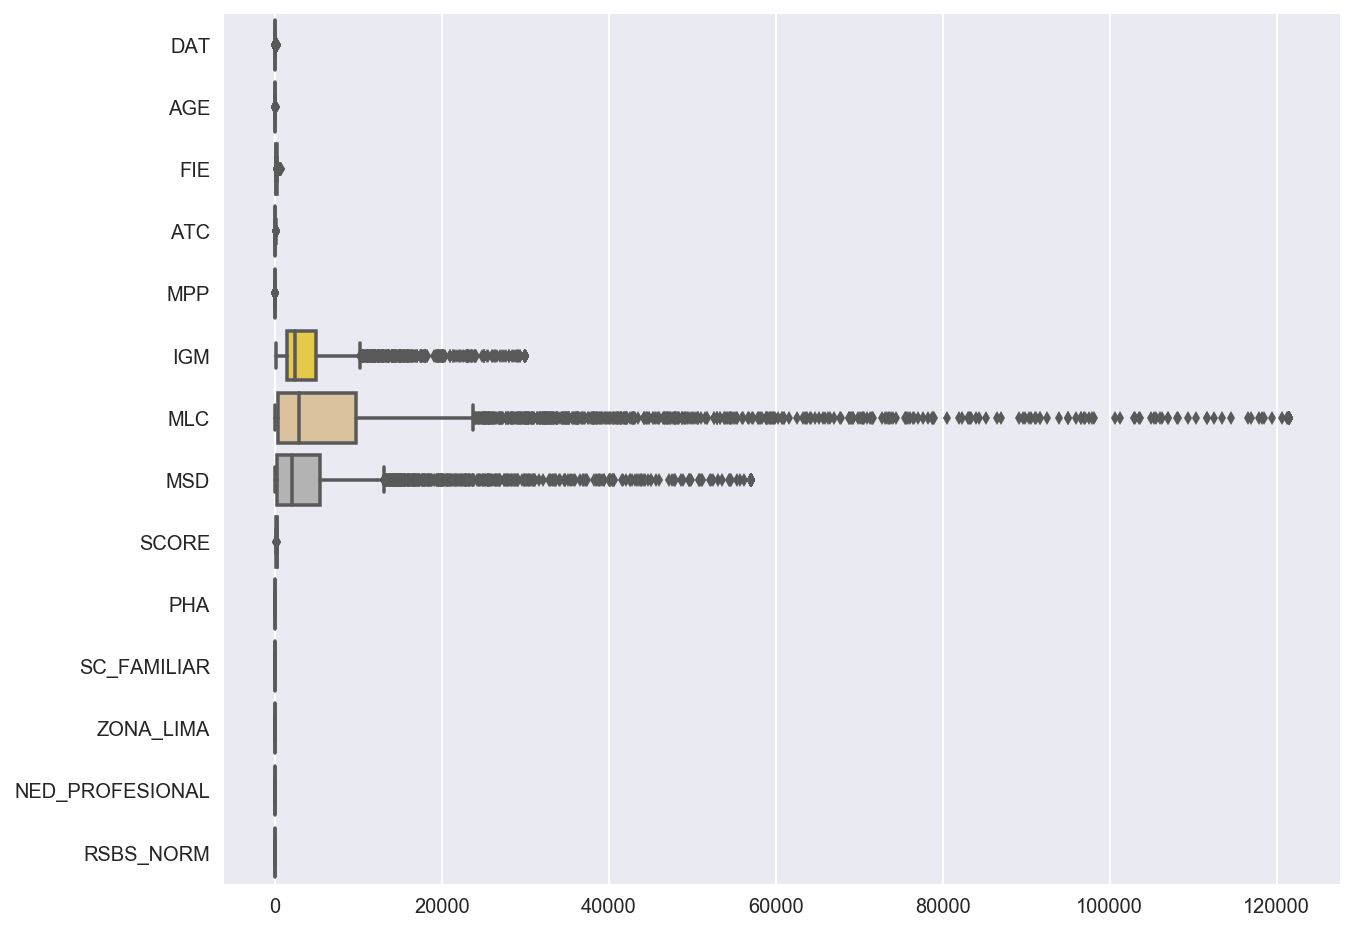

In [569]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=x, orient="h", palette="Set2");

In [570]:
def plot_dist_columns(n_rows, data, grapf, **kwargs):
    f, axs = plt.subplots(n_rows, 2, figsize=(30,30));
    for i in range(n_rows):
        grapf(data[predictors[2*i]], ax=axs[i,0], **kwargs);
        grapf(data[predictors[2*i+1]], ax=axs[i,1], **kwargs);
        axs[i,0].xaxis.label.set_size(15)
        axs[i,1].xaxis.label.set_size(15)

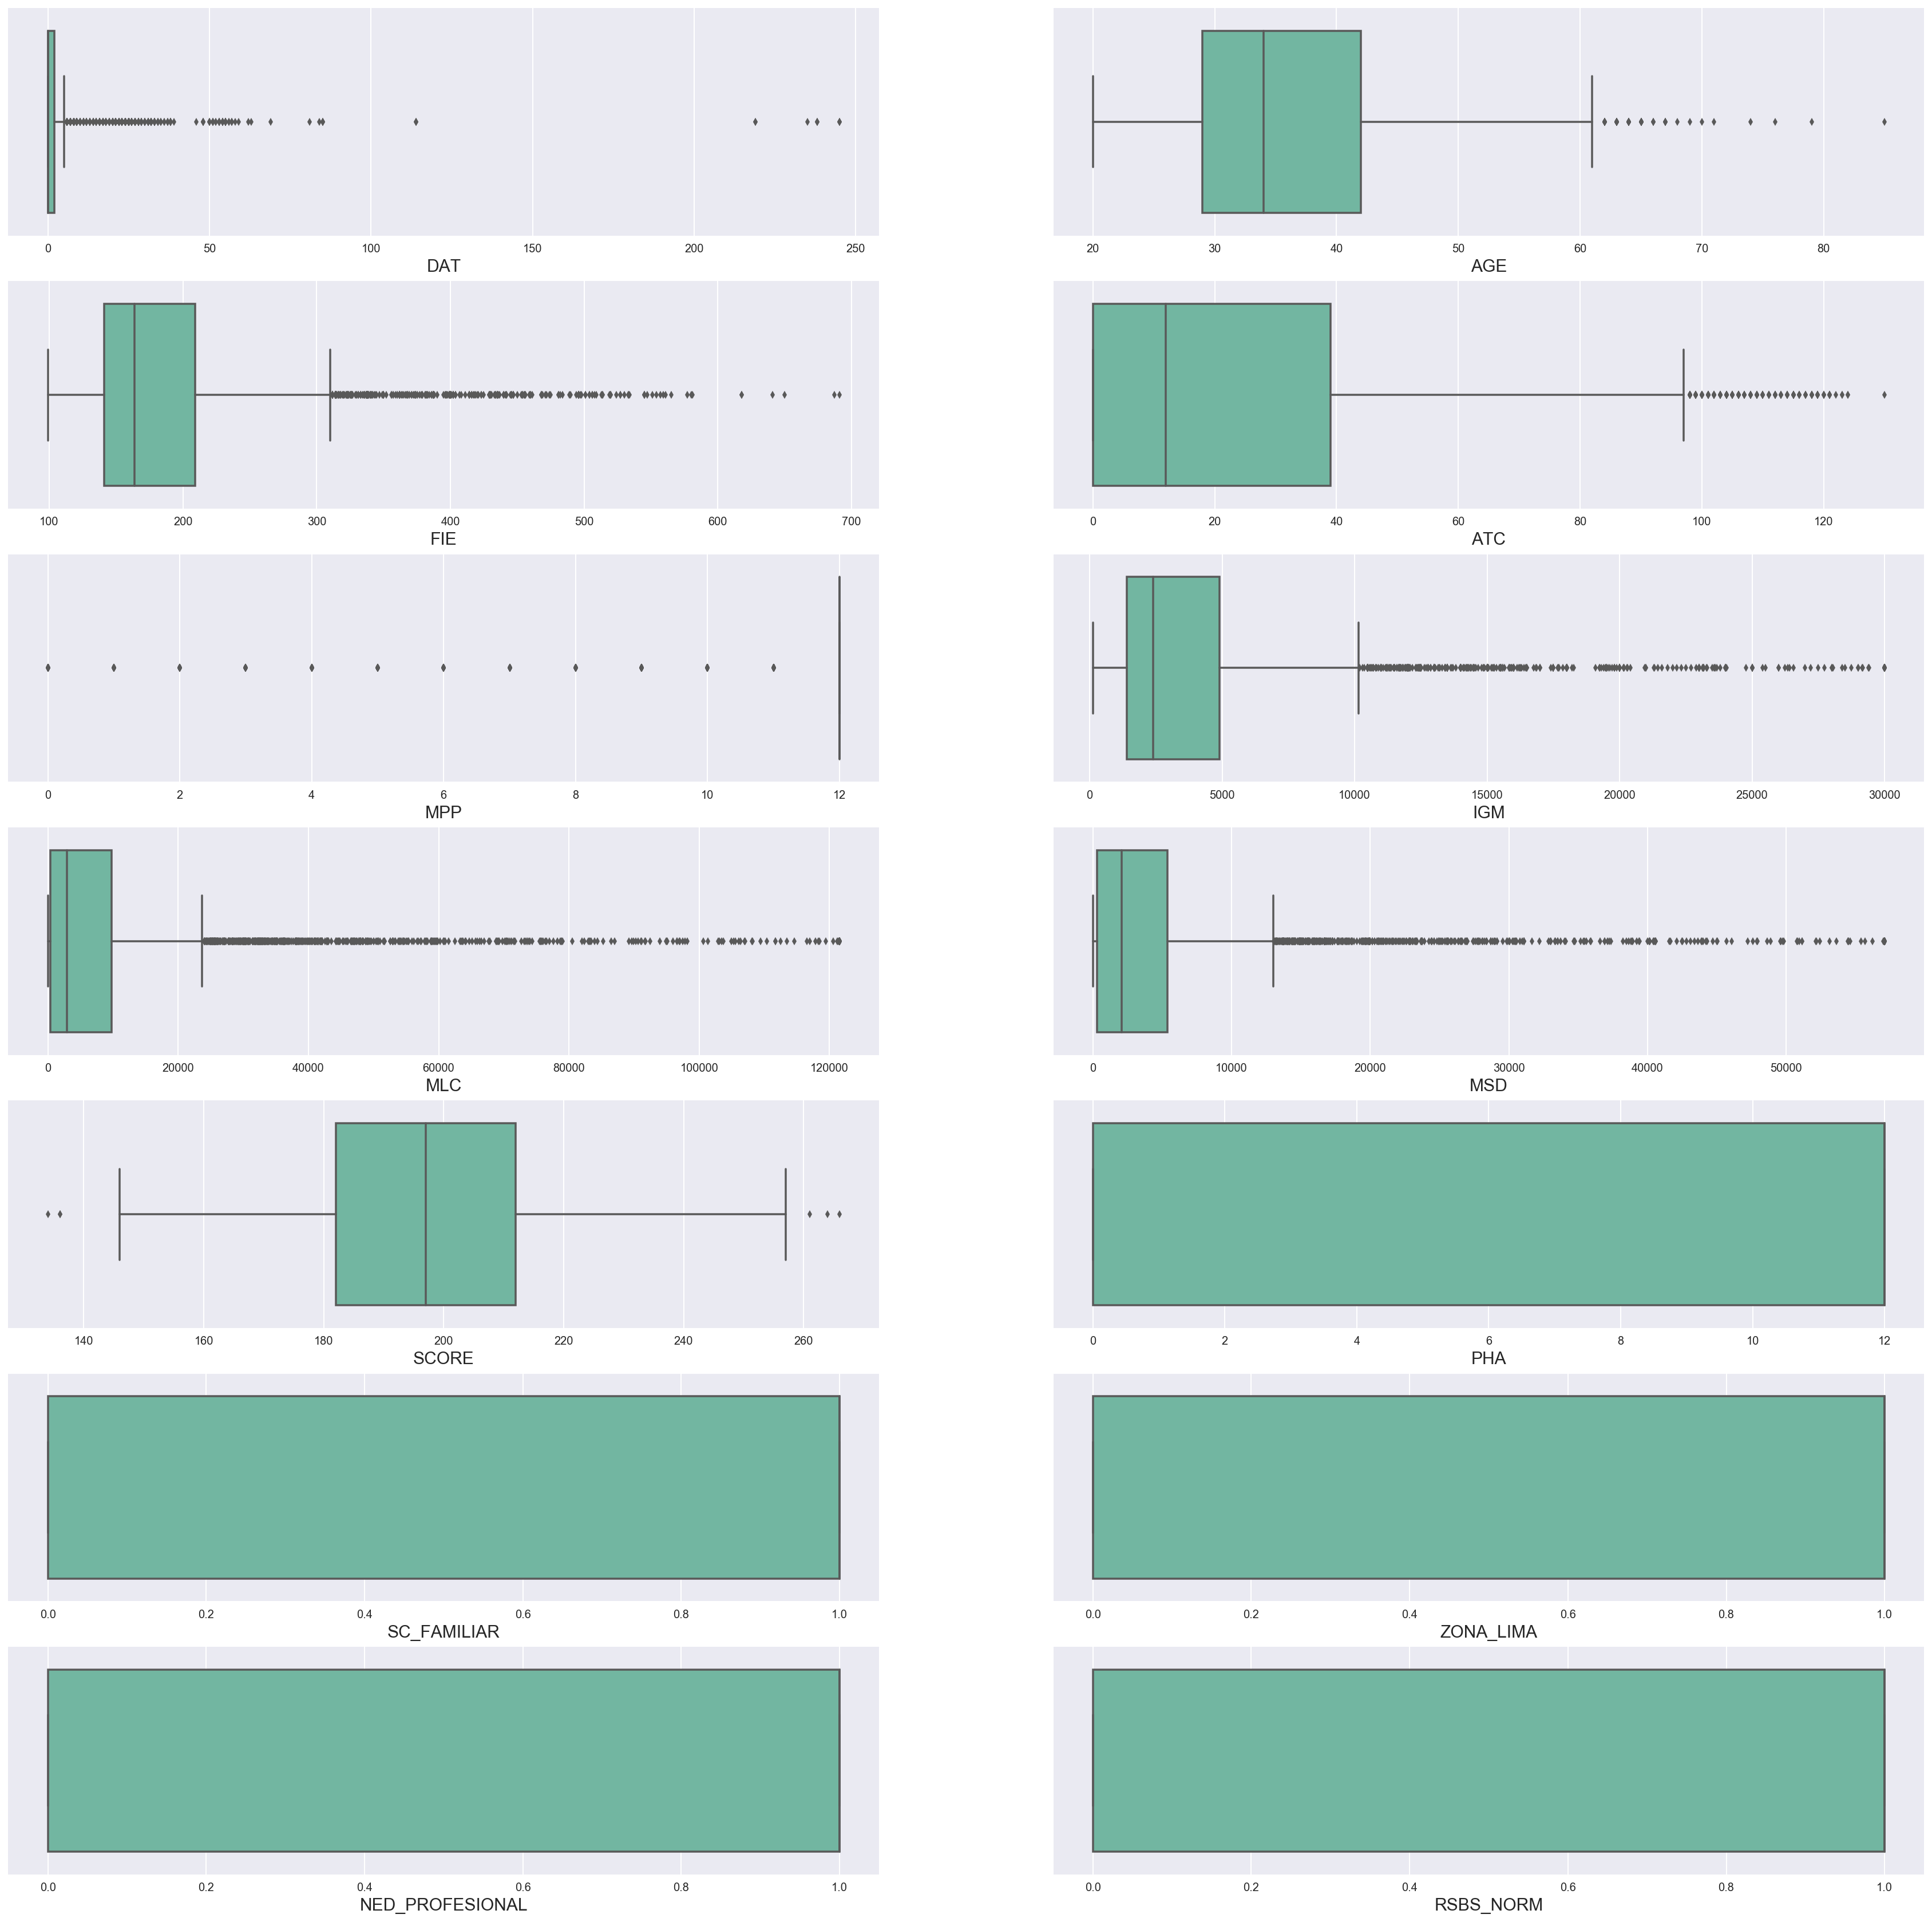

In [571]:
plot_dist_columns(7, x, sns.boxplot, palette="Set2")

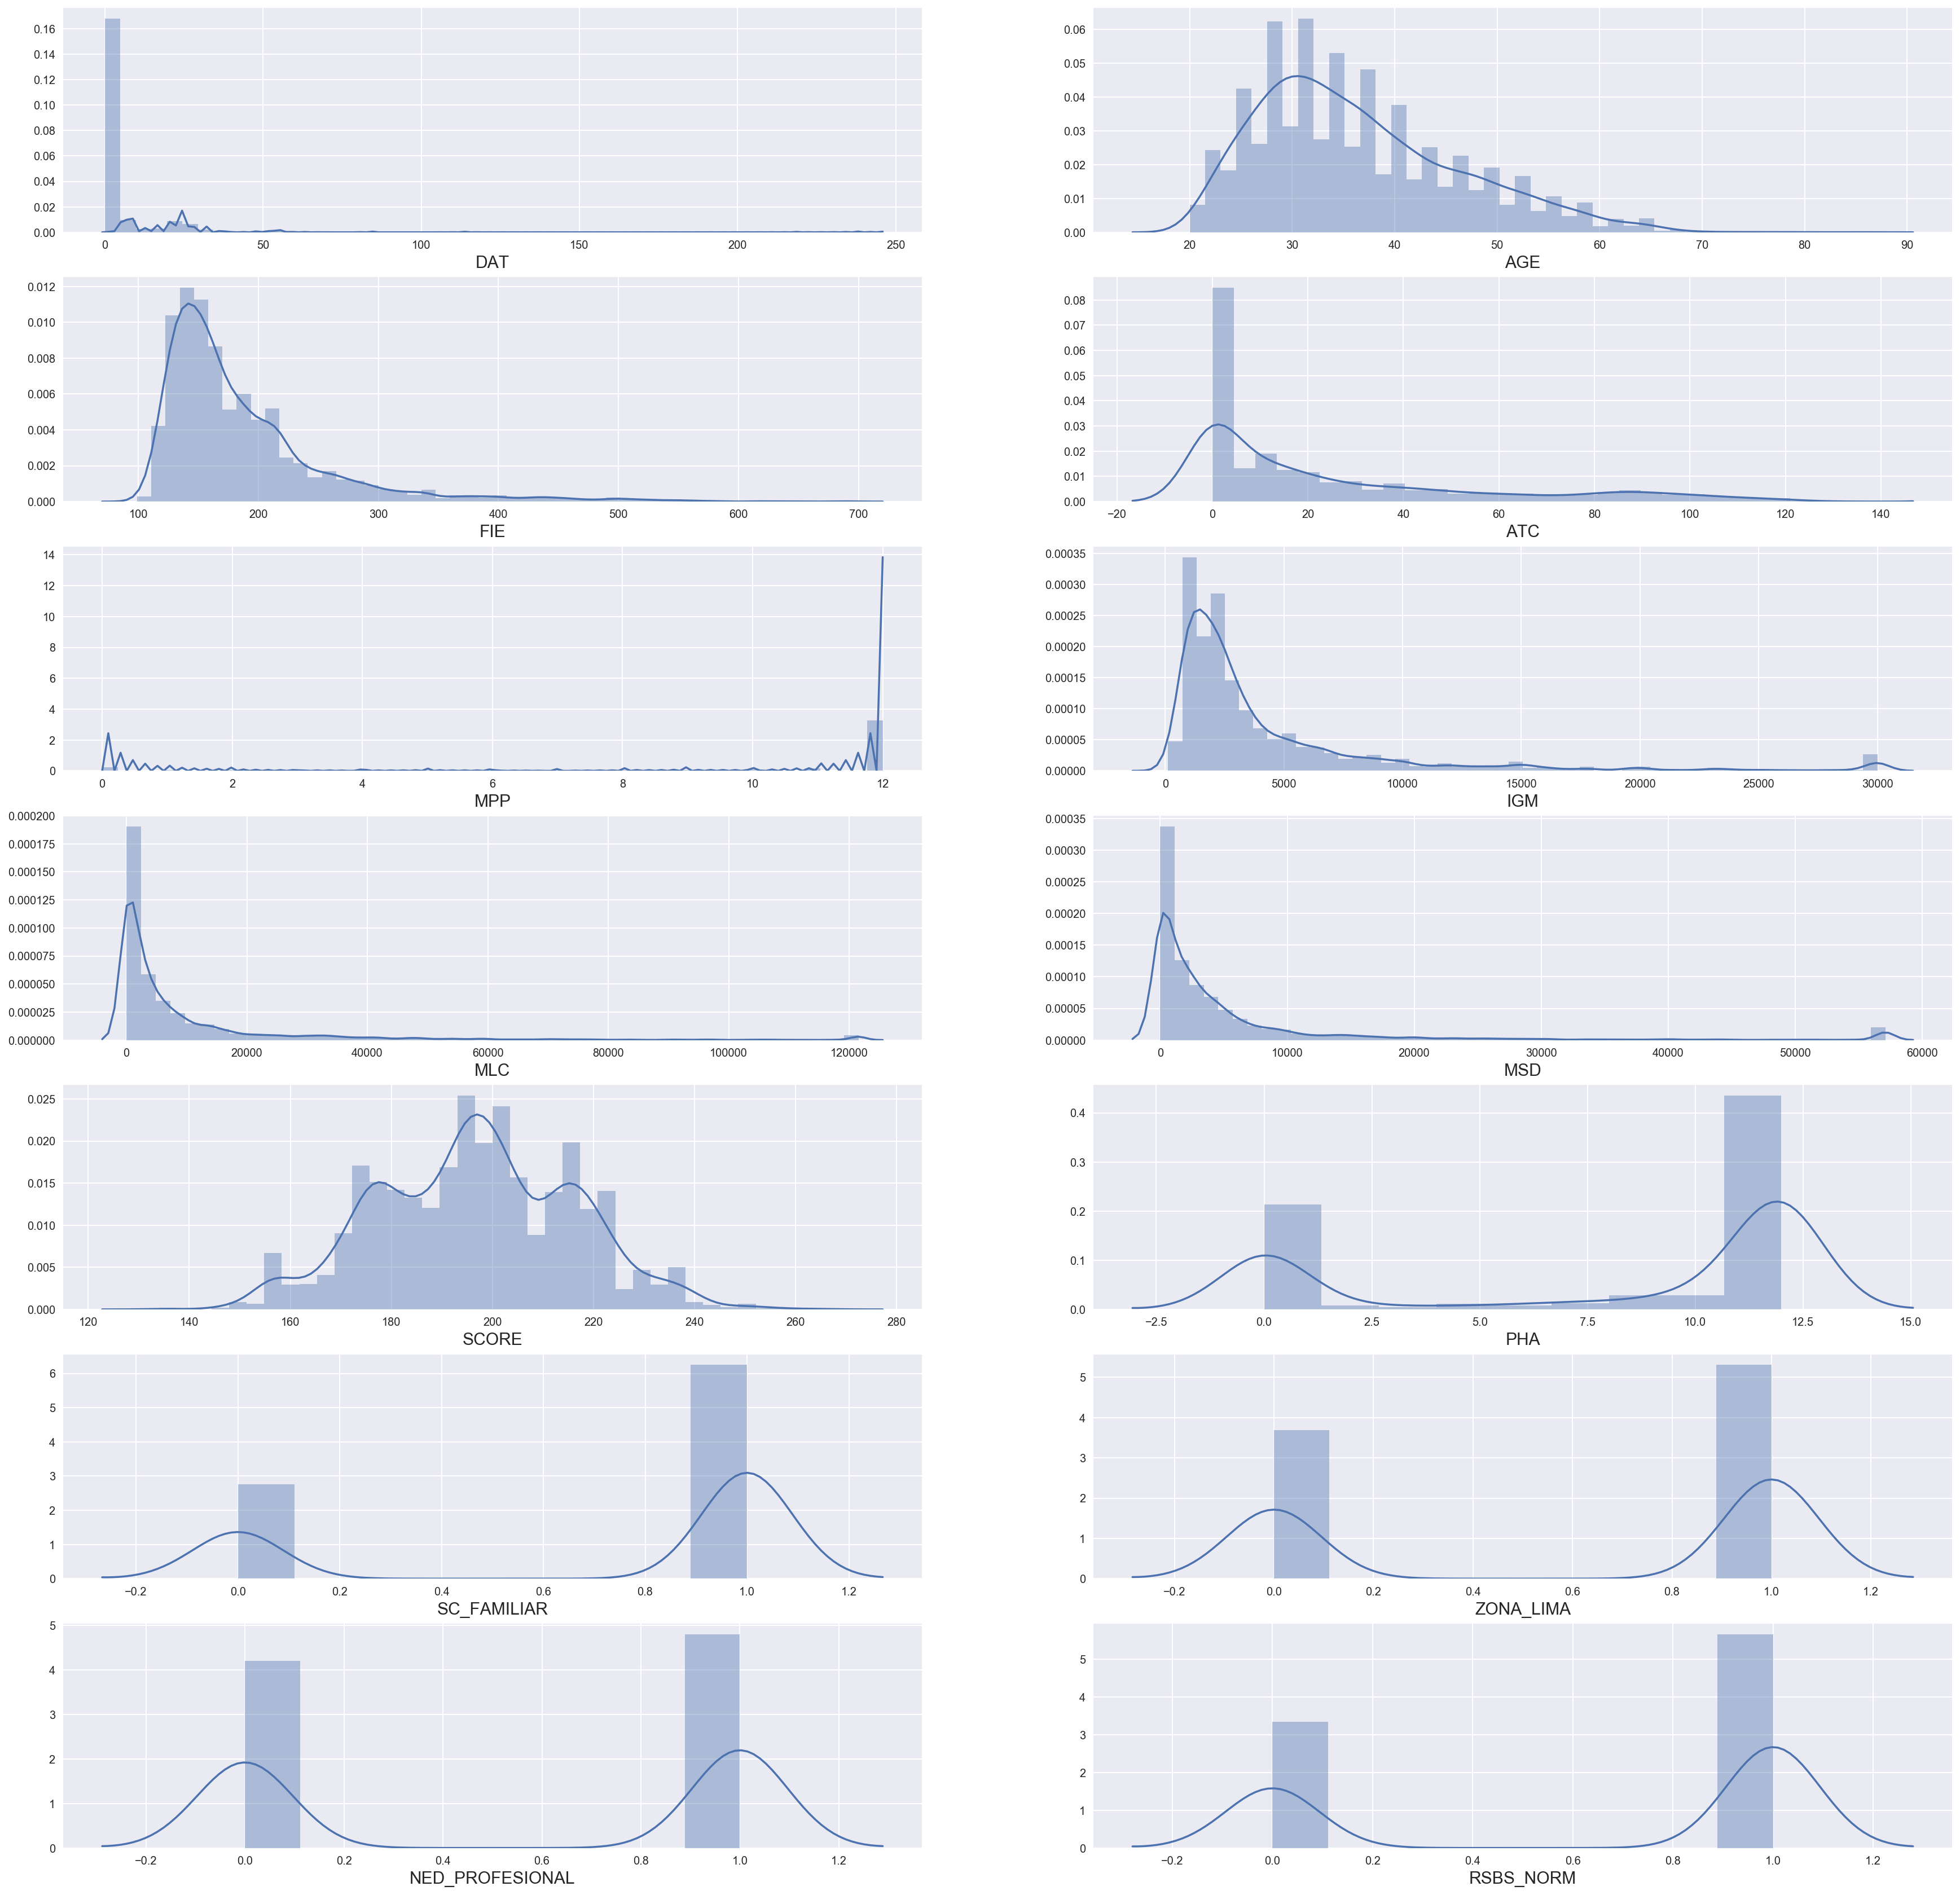

In [572]:
plot_dist_columns(7, x, sns.distplot)

## Plotting rescaled data 

In [573]:
def get_non_outliers(X):
    cutoffs = np.percentile(X, (0, 99))
    non_outliers_mask = (np.all(X.reshape(5000,1) > cutoffs[0], axis=1) & 
                         np.all(X.reshape(5000,1) < cutoffs[1], axis=1))
    return X[non_outliers_mask]


def get_non_outliers_full(X):
    cutoffs = np.percentile(X, (25, 75))
    ir = cutoffs[1] - cutoffs[0]
    return [ np.median(X) if (i < cutoffs[0]-1.5*ir or i > cutoffs[1]+1.5*ir) else i for i in X]

def get_non_outliers_df(df):
    cutoffs = np.percentile(df, (25, 75))
    ir = cutoffs[1] - cutoffs[0]
    mask =  [ False if (v < cutoffs[0]-1.5*ir or v > cutoffs[1]+1.5*ir) else True for v in df]
    return df[mask]

def plot_rescaled_comparation(X, n_features, f_transform):
    f, axs = plt.subplots(n_features, 2, figsize=(20,30));
    d = f_transform.fit_transform(x)
    for i in range(n_features):
        sns.distplot(d[:,i], ax=axs[i,0], axlabel='{} RESCALED'.format(predictors[i]));
        sns.distplot(get_non_outliers(d[:,i]), ax=axs[i,1], axlabel='{} RES WITHOUT OUTLIERS'.format(predictors[i]));

def plot_rescaled_comparation_full(X, n_features, f_transform):
    f, axs = plt.subplots(n_features, 2, figsize=(20,30));
    f.subplots_adjust(hspace=.5)
    d = f_transform.fit_transform(x)
    for i in range(n_features):
        sns.distplot(d[:,i], ax=axs[i,0], axlabel='{} RESCALED'.format(predictors[i]));
        sns.distplot(get_non_outliers_full(d[:,i]), ax=axs[i,1], axlabel='{} RES REPLACE OUTLIERS'.format(predictors[i]));

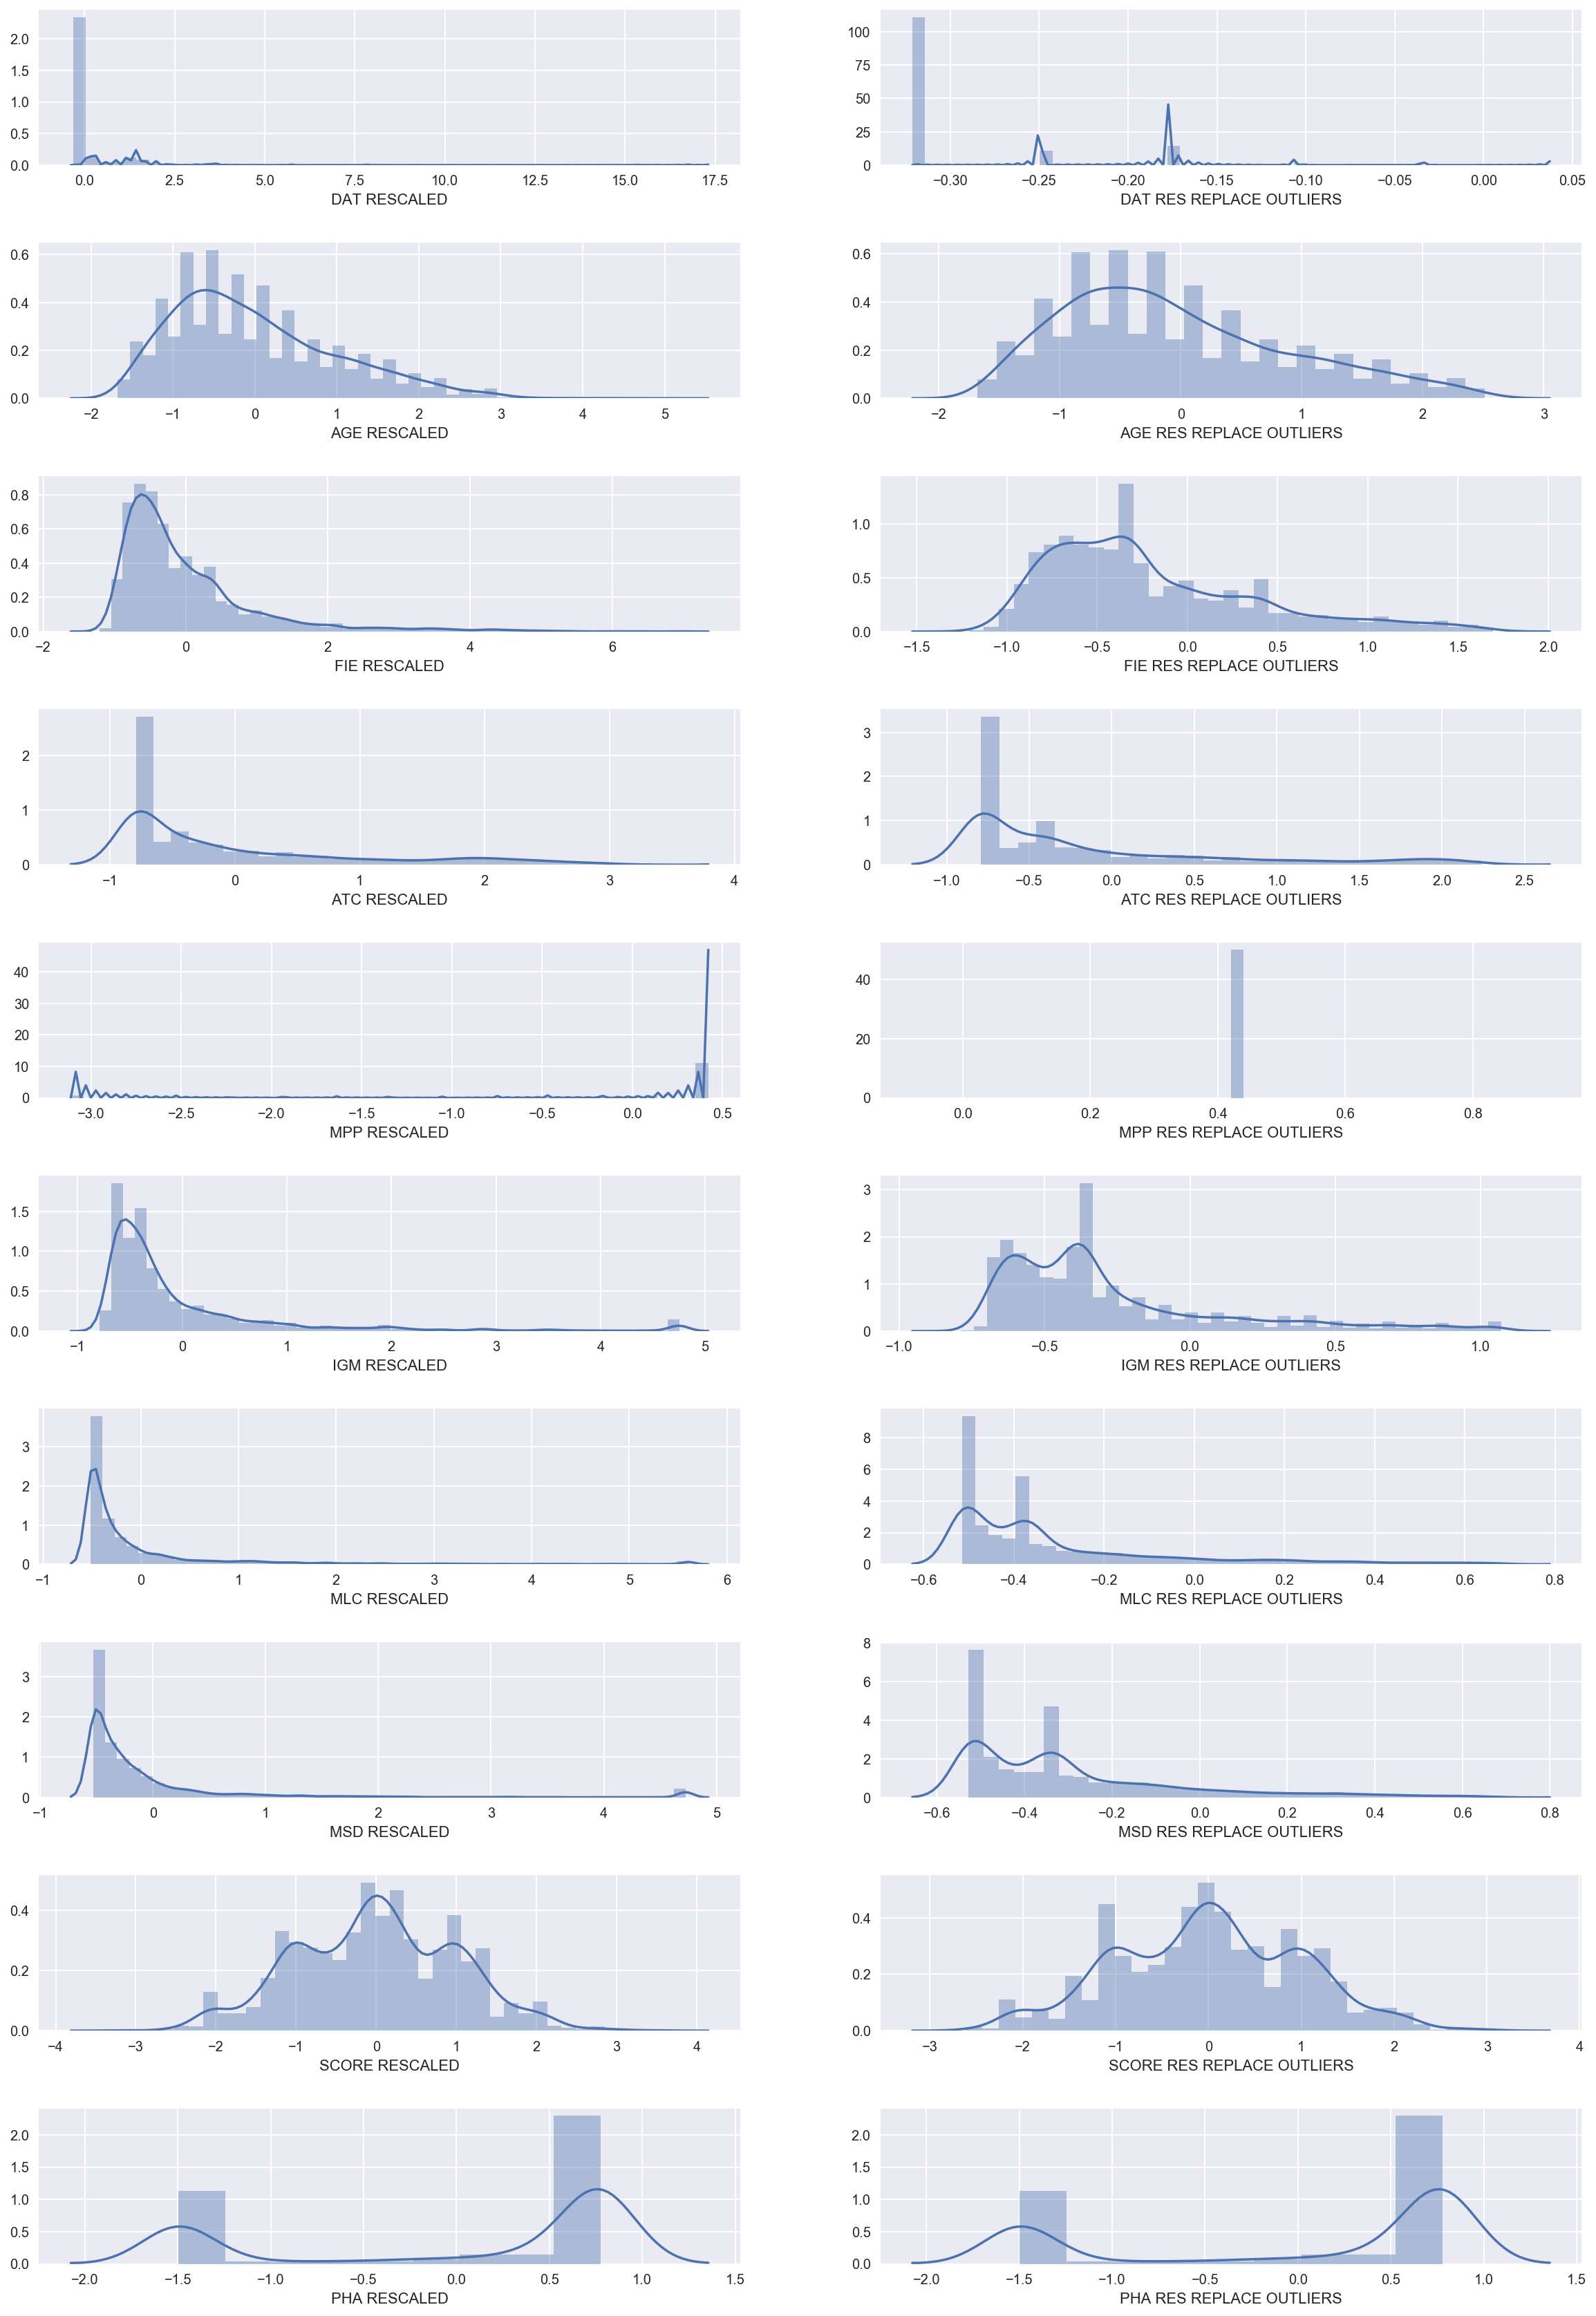

In [686]:
# SC
plot_rescaled_comparation_full(x, 10, StandardScaler())

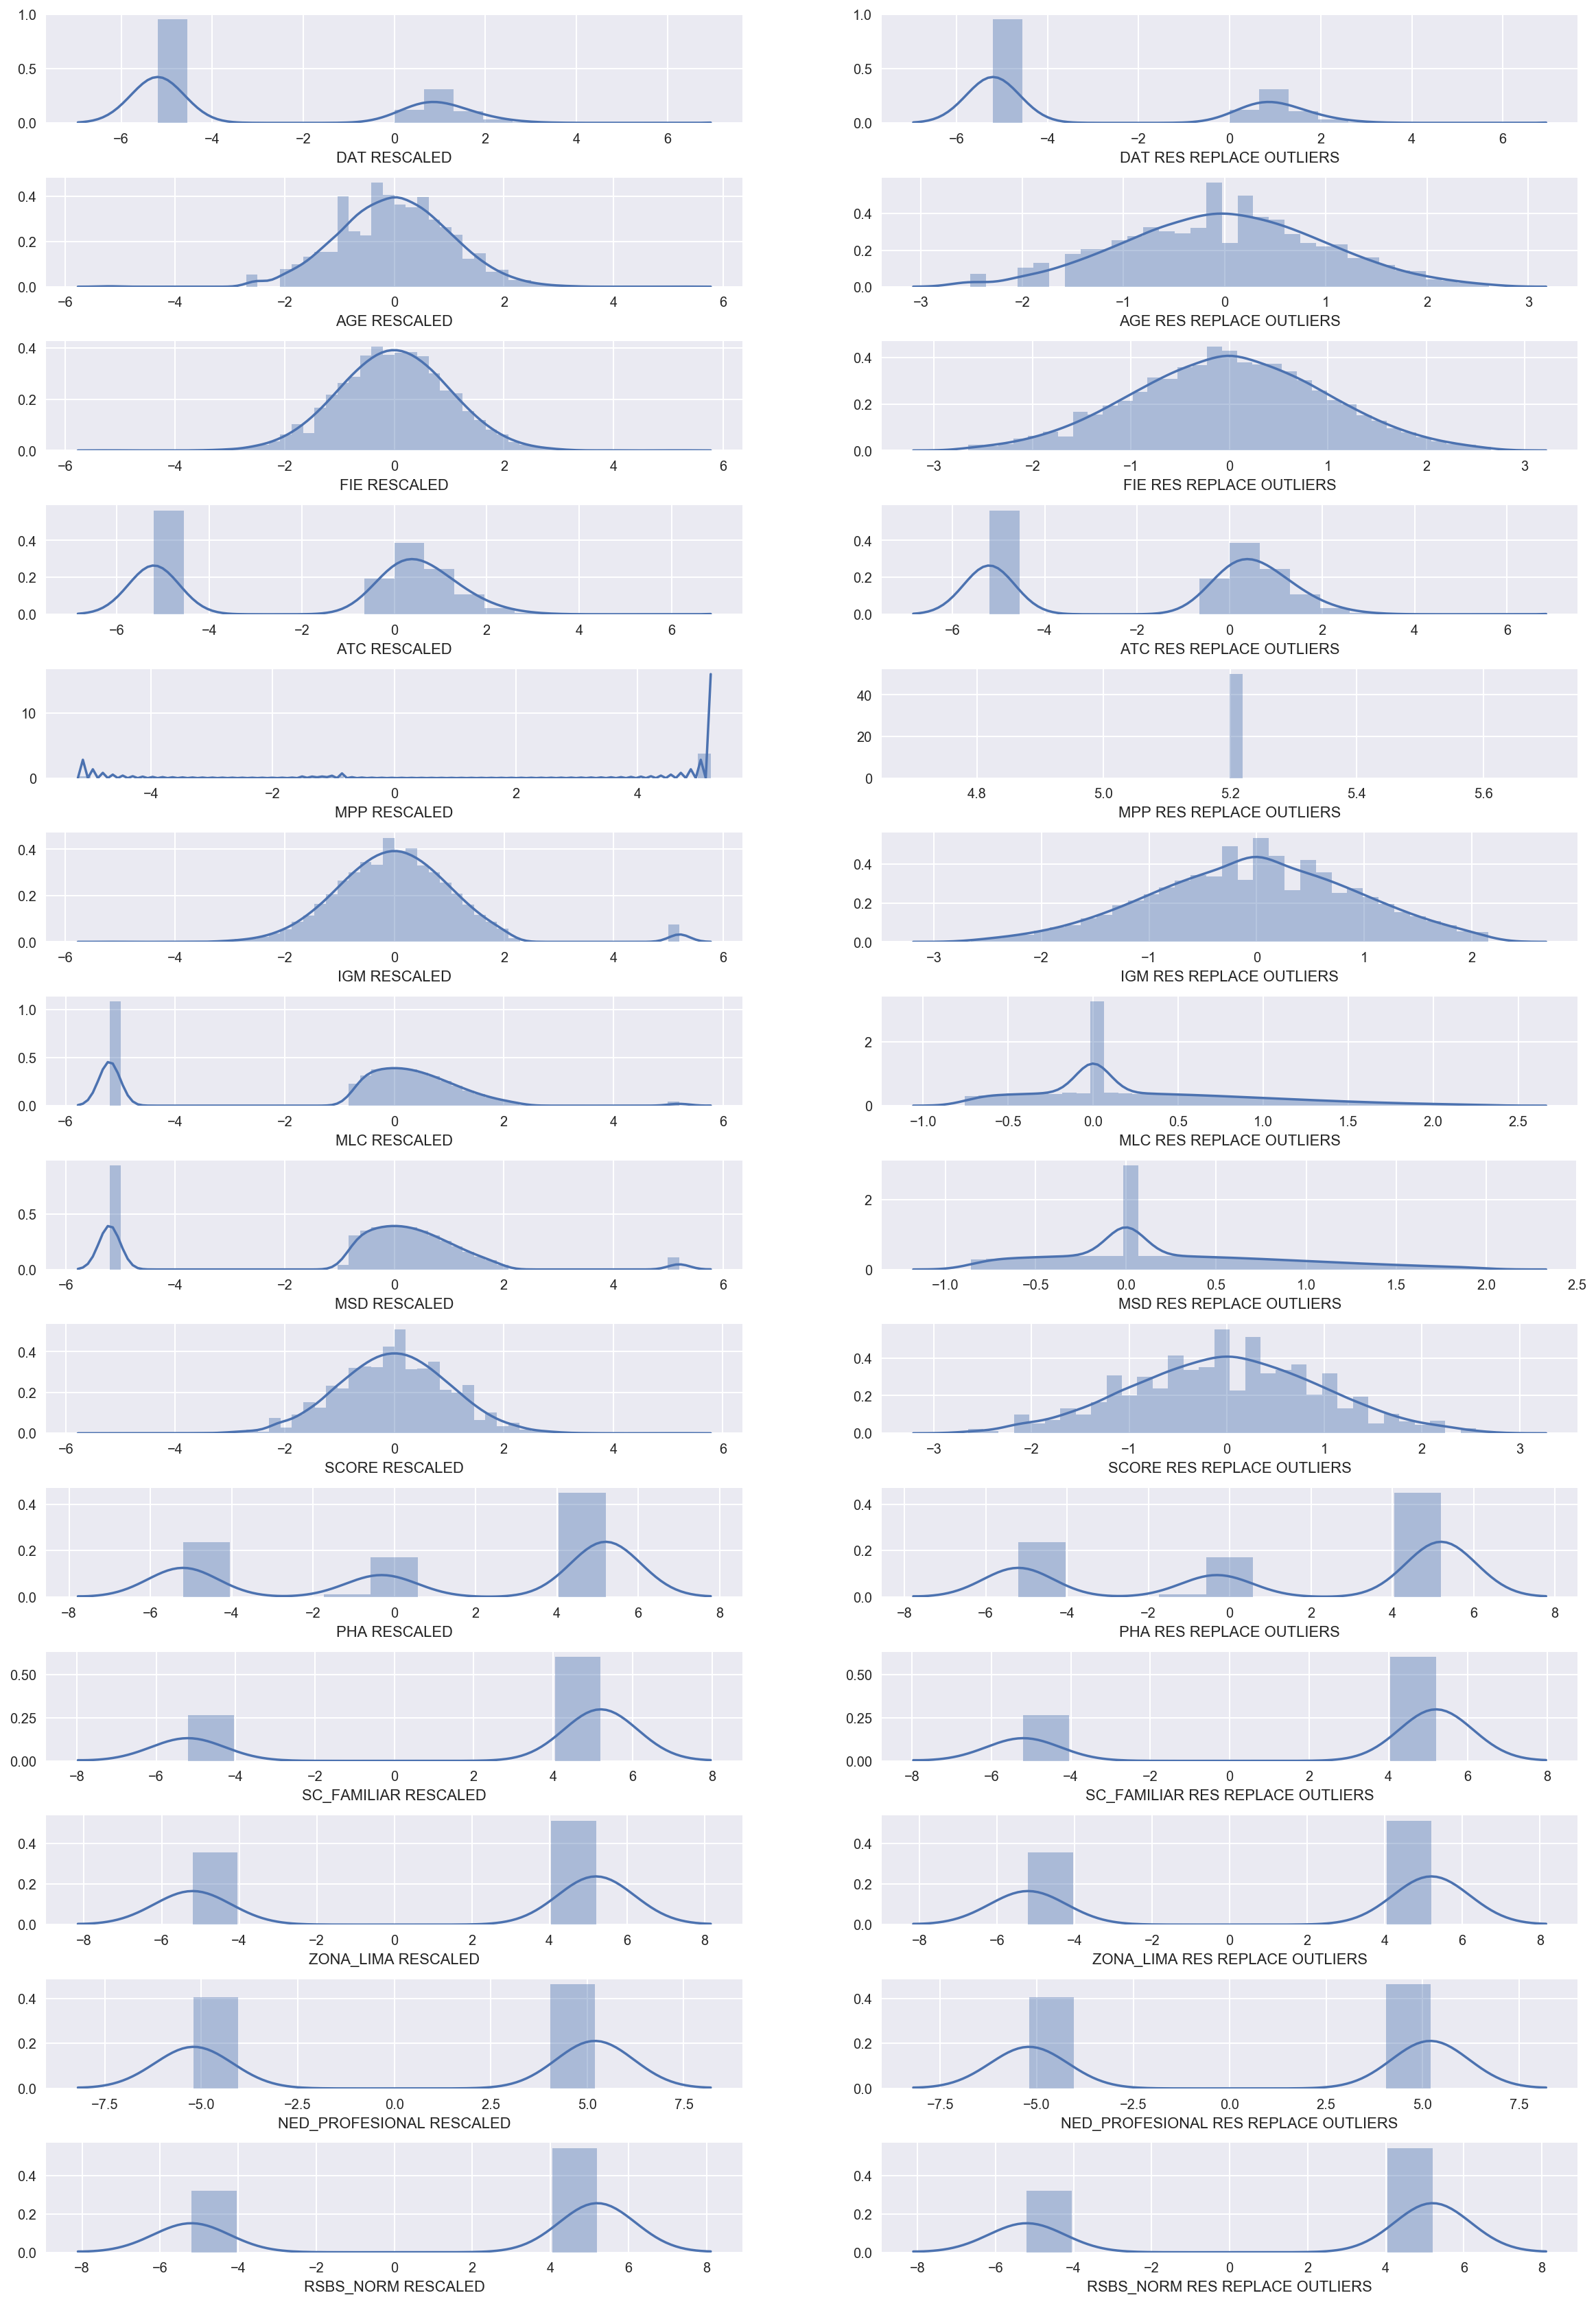

In [685]:
# QT
plot_rescaled_comparation_full(x, 14, QuantileTransformer(output_distribution='normal'))

## Modeling

In [576]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

In [577]:
x = ndf[predictors]
y = ndf['MORA60']

In [580]:
np.random.seed(42)

In [587]:
def get_auc_model(x_data, y_data, clf):
    results = []
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
    kfold = KFold(n=len(x_train), n_folds=10, random_state=42)
    results = cross_val_score(clf, x_train, y_train, cv=kfold, scoring='roc_auc')
    print("AUC: %.3f%% (%.3f%%)") % (results.mean()*100.0, results.std()*100.0)

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print ("AUC TEST: {:.3f}%".format(roc_auc_score(y_test, y_pred)*100))

### Fiting con raw data

In [588]:
get_auc_model(x, y, LogisticRegression(penalty='l1'))

AUC: 72.305% (3.877%)
AUC TEST: 59.017%


### Fitting con data rescalada

In [589]:
estimators = []
estimators.append(('QuanTransformer', QuantileTransformer(output_distribution='normal')))
estimators.append(('LR', LogisticRegression(penalty='l1')))
model = Pipeline(estimators)

get_auc_model(x, y, model)

AUC: 72.660% (3.041%)
AUC TEST: 59.739%


In [590]:
estimators = []
estimators.append(('StandardScaler', StandardScaler()))
estimators.append(('LR', LogisticRegression(penalty='l1')))
model = Pipeline(estimators)

get_auc_model(x, y, model)

AUC: 72.323% (3.829%)
AUC TEST: 59.173%


### Fitting con fliers reemplazados luego del rescaler

In [591]:
# ======================>  QuantileTransform 

new_x =  QuantileTransformer(output_distribution='normal').fit_transform(x)
dq = pd.DataFrame()
for i in range(len(predictors)):
    dq[predictors[i]] = get_non_outliers_full(new_x[:,i])

get_auc_model(dq, y, LogisticRegression(penalty='l1'))

AUC: 72.349% (3.771%)
AUC TEST: 60.328%


In [592]:
#StandarScaler

new_x =  StandardScaler().fit_transform(x)
dq = pd.DataFrame()
for i in range(len(predictors)):
    dq[predictors[i]] = get_non_outliers_full(new_x[:,i])

get_auc_model(dq, y, LogisticRegression(penalty='l1'))

AUC: 70.758% (3.537%)
AUC TEST: 57.066%


### Fitting con fliers reemplazados antes del rescaler

In [593]:
dsf = pd.DataFrame()
for i in range(len(predictors)):
    dsf[predictors[i]] = get_non_outliers_full(x[predictors[i]])

In [594]:
# QT
new_qt =  QuantileTransformer(output_distribution='normal').fit_transform(dsf)
get_auc_model(new_qt, y, LogisticRegression(penalty='l1'))

AUC: 71.015% (3.394%)
AUC TEST: 58.139%


In [595]:
# SC
new_sc =  StandardScaler().fit_transform(dsf)
get_auc_model(new_sc, y, LogisticRegression(penalty='l1'))

AUC: 70.789% (3.494%)
AUC TEST: 56.919%



### Fitting con fliers reemplazados antes y después del rescaler

In [596]:
# QT
dff = pd.DataFrame()
for i in range(len(predictors)):
    dff[predictors[i]] = get_non_outliers_full(new_qt[:,i]) 
get_auc_model(dff, y, LogisticRegression(penalty='l1'))

AUC: 70.815% (3.822%)
AUC TEST: 57.836%


In [597]:
# SC
dff = pd.DataFrame()
for i in range(len(predictors)):
    dff[predictors[i]] = get_non_outliers_full(new_sc[:,i]) 
get_auc_model(dff, y, LogisticRegression(penalty='l1'))

AUC: 70.234% (3.971%)
AUC TEST: 56.672%


## Reduciendo el overfitting

In [599]:
# QuantileTransform 

model = LogisticRegression(penalty='l1')
x_qt=  QuantileTransformer(output_distribution='normal').fit_transform(x)

x_std = pd.DataFrame()
for i in range(len(predictors)):
    x_std[predictors[i]] = get_non_outliers_full(x_qt[:,i])

x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2, random_state=42)
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [600]:
#Feature selection en base a los pesos
model.coef_[0]

array([ 0.06398075,  0.02714693, -0.148537  , -0.08684384,  0.24493147,
       -0.38657435, -0.25111839,  0.25260997, -0.28534821, -0.0744704 ,
       -0.00938401, -0.01047749, -0.00209501, -0.06407315])

## Plotting pesos

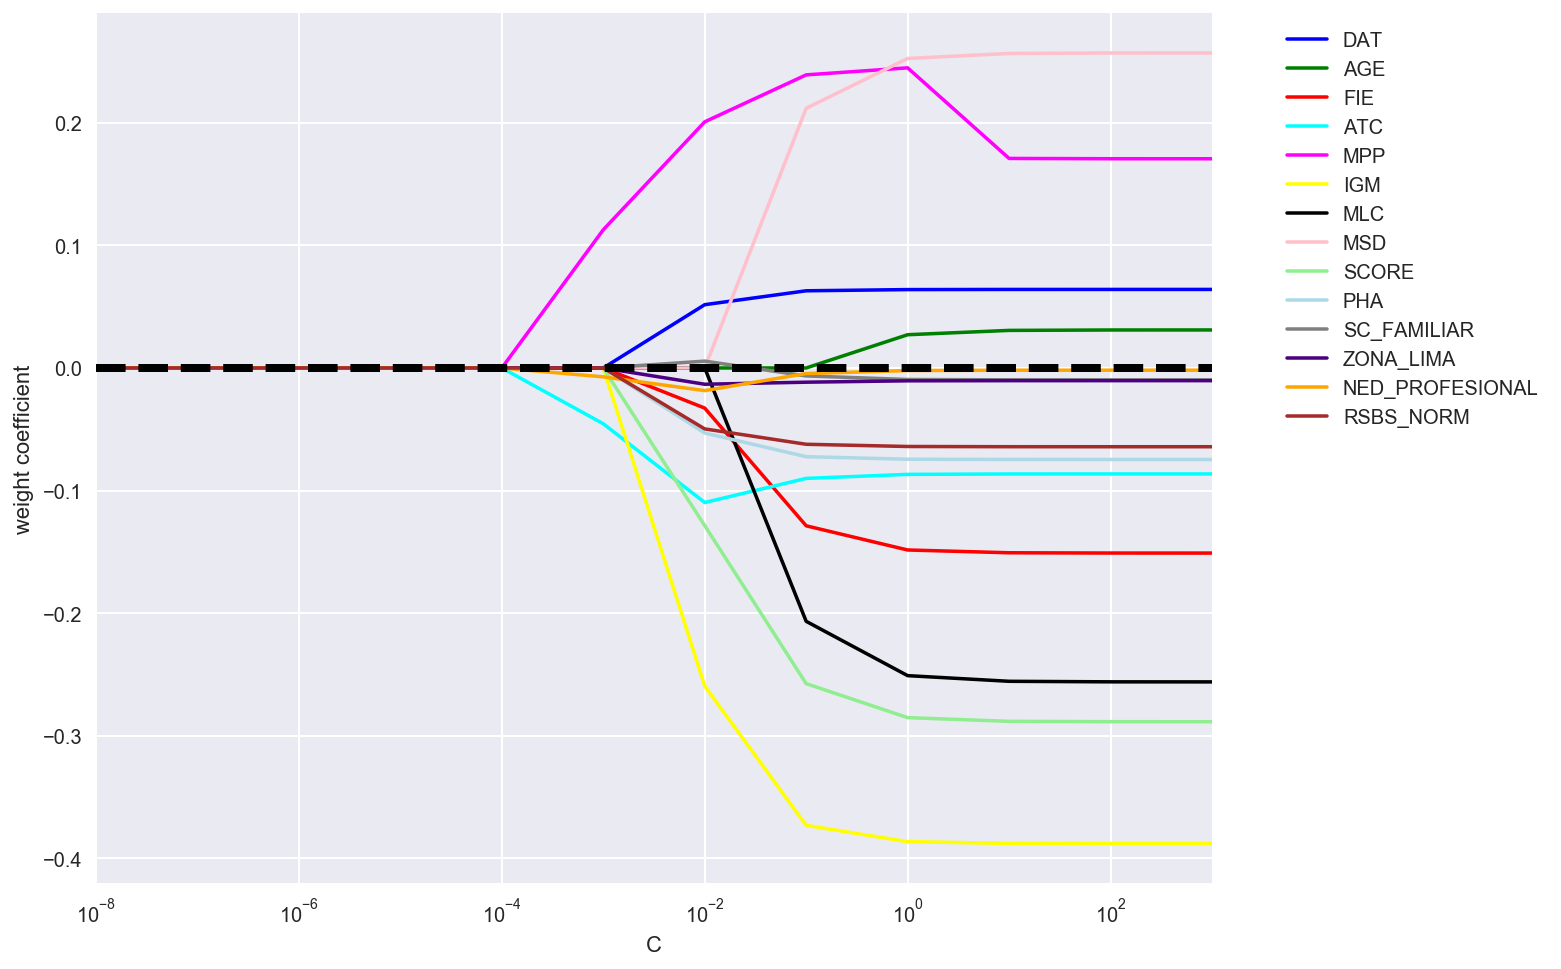

In [624]:
fig, ax = plt.subplots(figsize=(10,8))
colors = ['blue', 'green', 'red', 'cyan',
            'magenta', 'yellow', 'black',
            'pink', 'lightgreen', 'lightblue',
            'gray', 'indigo', 'orange', 'brown']
weights, params = [], []

exp = np.arange(-8,4)
ran = list(map(int, exp))

for c in ran:
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(x_train, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
    label=x.columns[column],
    color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=4)
plt.xlim([10**(ran[0]), 10**ran[-1]])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
bbox_to_anchor=(1.18, 1.),ncol=1, fancybox=True)

In [675]:
from sklearn.learning_curve import validation_curve

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

pipe_lr = Pipeline([('scl', QuantileTransformer(output_distribution='normal')),
                    ('clf', LogisticRegression(penalty='l1', random_state=42))])
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
train_scores, test_scores = validation_curve(
                                            estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='clf__C',
                                            param_range=param_range,
                                            cv=10,
                                            scoring='roc_auc')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

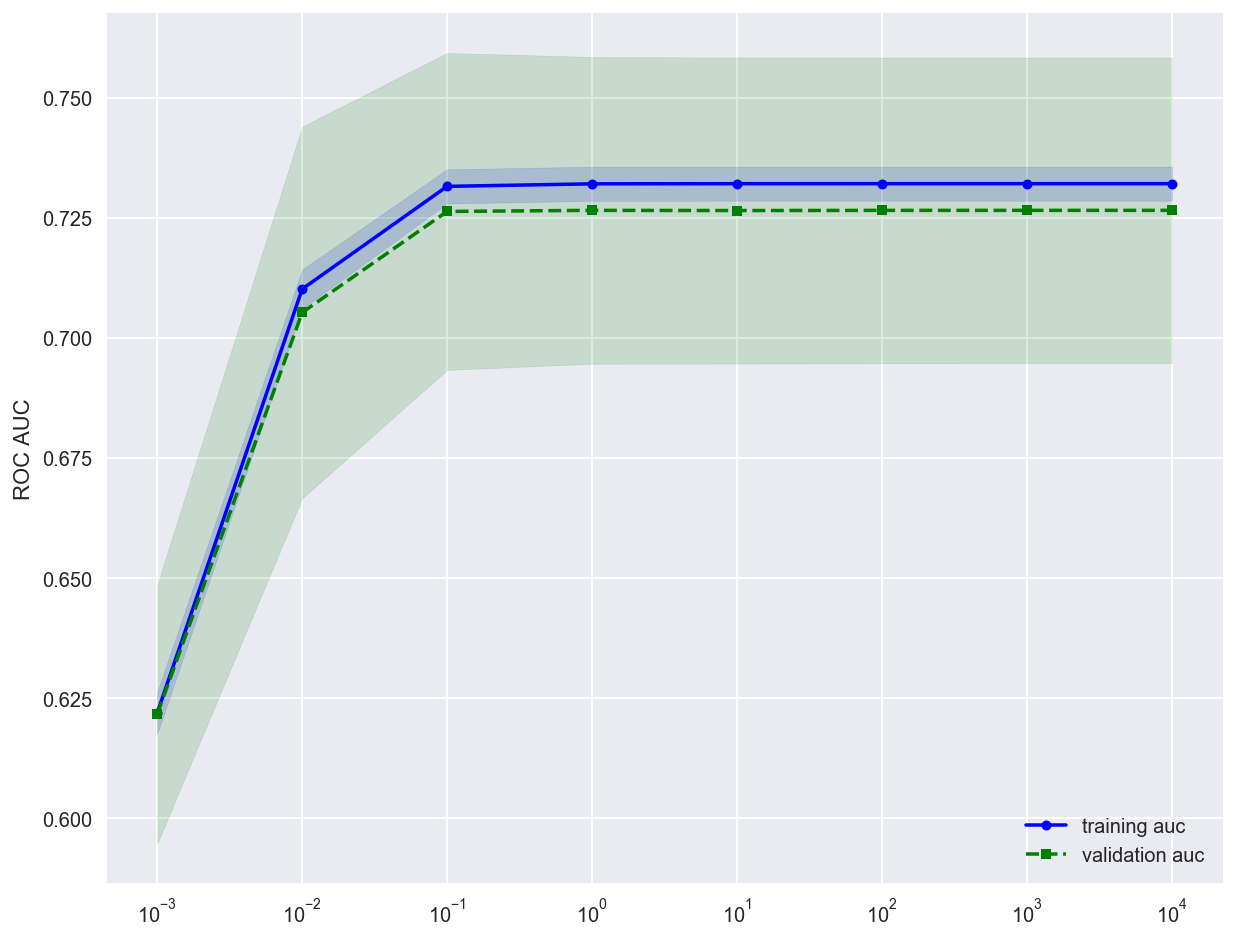

In [676]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5,
        label='training auc')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5,
        label='validation auc')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std,
        alpha=0.15, color='green')
plt.xscale('log')
plt.ylabel('ROC AUC')
plt.legend(loc='lower right')

In [677]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores =  learning_curve(estimator=pipe_lr,
                                                         X=X_train,
                                                         y=y_train,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         cv=10,
                                                         n_jobs=1,
                                                         scoring='roc_auc')
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

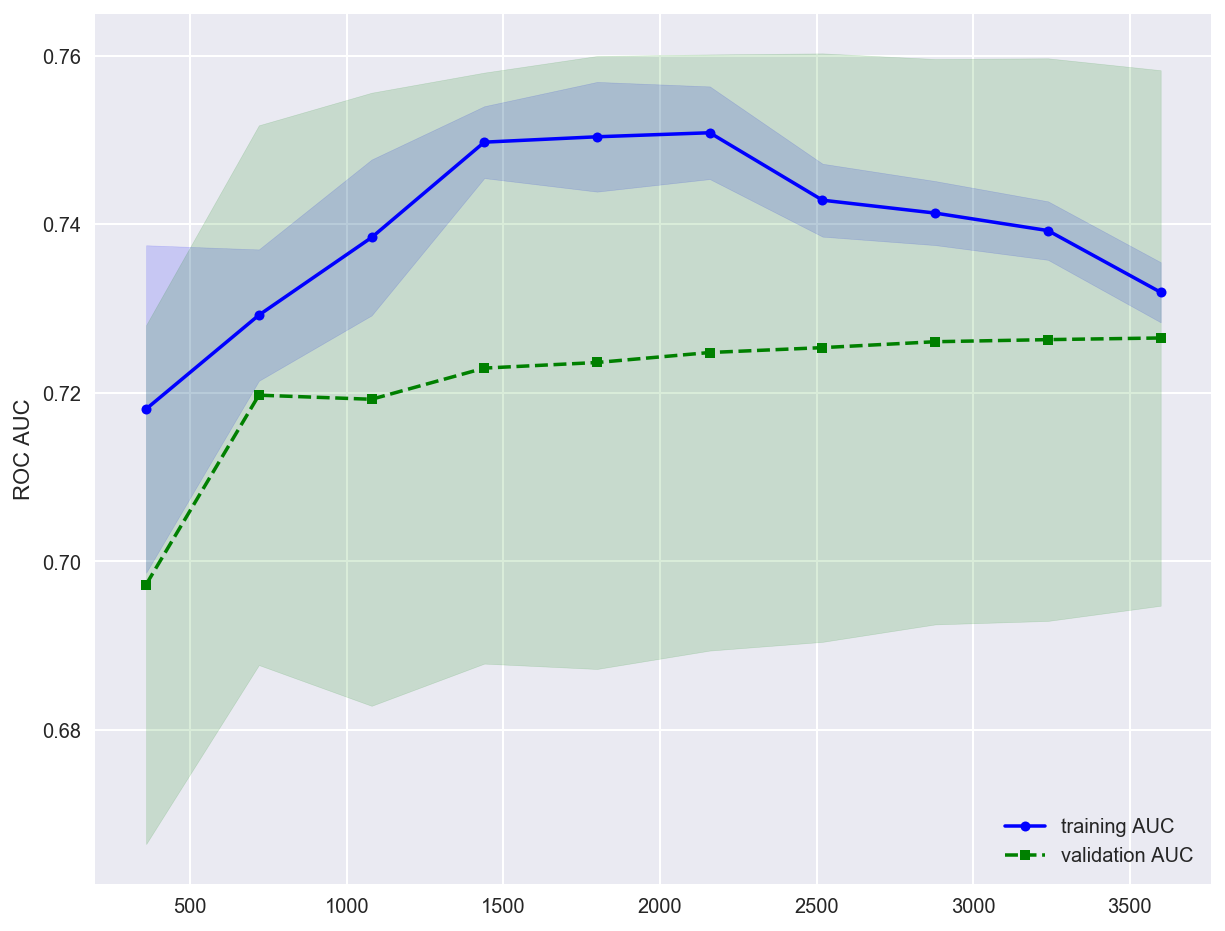

In [683]:
f, ax = plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training AUC')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation AUC')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.ylabel('ROC AUC')
plt.legend(loc='lower right')

## Feature importance

In [602]:
# Importance by weight and std_feature
pd.set_option('precision', 3)

feat = x_train.get_values()
rank = pd.DataFrame(model.coef_[0] , columns=['COEF'])
rank['IMPORTANCE'] = np.transpose(np.std(feat,0)*model.coef_)
rank['RANK'] = rank['IMPORTANCE'].rank().get_values()
rank['RANK'] = map(int, rank['RANK'])
rank['FEAT'] = np.array(x_train.columns)
rank

,COEF,IMPORTANCE,RANK,FEAT
0,0.064,1.938e-01,14,DAT
1,0.027,2.662e-02,12,AGE
2,-0.149,-1.433e-01,7,FIE
3,-0.087,-2.466e-01,5,ATC
4,0.245,2.175e-16,11,MPP
5,-0.387,-3.626e-01,1,IGM
6,-0.251,-1.573e-01,6,MLC
7,0.253,1.558e-01,13,MSD
8,-0.285,-2.744e-01,4,SCORE
9,-0.074,-3.297e-01,2,PHA


In [687]:
x = ndf[predictors]
y = ndf['MORA60']

new_x =  QuantileTransformer(output_distribution='normal').fit_transform(x)
dq = pd.DataFrame()
for i in range(len(predictors)):
    dq[predictors[i]] = np.array(get_non_outliers_full(new_x[:,i]))

x_train, x_test, y_train, y_test = train_test_split(dq, y, test_size=0.2, random_state=42)

In [610]:
import statsmodels.api as sm

logit = sm.Logit(y_train, x_train)

# fit the model
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.534975
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 MORA60   No. Observations:                 4000
Model:                          Logit   Df Residuals:                     3986
Method:                           MLE   Df Model:                           13
Date:                Fri, 20 Oct 2017   Pseudo R-squ.:                  0.1177
Time:                        01:12:08   Log-Likelihood:                -2139.9
converged:                       True   LL-Null:                       -2425.4
                                        LLR p-value:                1.158e-113
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
DAT                 0.0641      0.013      4.825      0.000       0.038       0.090
AGE                 0.0311      0.047      0.656      0.512      -0.062       0.124
FIE                -0.1511      0.045     -3.393      0.001      -0.238      -0.064
ATC                -0.0865      0.015     -5.639      0.000      -0.117      -0.056
MPP                 0.2456      0.013     18.371      0.000       0.219       0.272
IGM                -0.3882      0.057     -6.803      0.000      -0.500      -0.276
MLC                -0.2563      0.069     -3.696      0.000      -0.392      -0.120
MSD                 0.2571      0.062      4.121      0.000       0.135       0.379
SCORE              -0.2888      0.056     -5.124      0.000      -0.399      -0.178
PHA                -0.0747      0.009     -8.369      0.000      -0.092      -0.057
SC_FAMILIAR        -0.0097      0.009     -1.083      0.279      -0.027       0.008
ZONA_LIMA          -0.0103      0.008     -1.339      0.181      -0.025       0.005
NED_PROFESIONAL    -0.0018      0.009     -0.211      0.833      -0.019       0.015
RSBS_NORM          -0.0643      0.008     -8.077      0.000      -0.080      -0.049
===================================================================================
"""

In [688]:
d = np.exp(result.params)
pd.DataFrame(d, columns=['ODDS RATIO'])

,ODDS RATIO
DAT,1.066
AGE,1.032
FIE,0.860
ATC,0.917
MPP,1.278
IGM,0.678
MLC,0.774
MSD,1.293
SCORE,0.749
PHA,0.928


In [690]:
clf_opt = LogisticRegression(penalty='l1', C=0.01)
clf_opt.fit(x_train, y_train)
y_pred = clf_opt.predict_proba(x_test)

d_test = pd.DataFrame(x_test)
d_test['MORA60'] = y_test

d_test['MORA_PRED'] = y_pred[:,1]
pred_ord = d_test.sort_values(['MORA_PRED'], ascending=True)
rango_deciles = pd.qcut(pred_ord['MORA_PRED'], 10)

In [692]:
def plot_lift(grupos, ylabel):
    my_colors = [(x/10.0, x/20.0, 0.4) for x in range(10)]
    f, ax = plt.subplots(figsize=(8, 6))
    grupos['mean'].groupby([grupos.index]).sum().plot(kind='bar', color=my_colors);
    plt.ylabel(ylabel);
    plt.title('LIFT CHART')

    for tick in ax.get_xticklabels():
            tick.set_rotation(-45)

In [709]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score

x = ndf[predictors]
y = ndf['MORA60']

new_x =  QuantileTransformer(output_distribution='normal').fit_transform(x)
dq = pd.DataFrame()
for i in range(len(predictors)):
    dq[predictors[i]] = np.array(get_non_outliers_full(new_x[:,i]))
    
pipeline = Pipeline([('clf', LogisticRegression())])
parameters = {
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='roc_auc', cv=3)
X_train, X_test, y_train, y_test = train_test_split(dq, y)
grid_search.fit(X_train, y_train)
print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set:'
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print '\t%s: %r' % (param_name, best_parameters[param_name])
predictions = grid_search.predict(X_test)
print 'Accuracy:', accuracy_score(y_test, predictions)
print 'Precision:', precision_score(y_test, predictions)
print 'Recall:', recall_score(y_test, predictions)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best score: 0.715
Best parameters set:
	clf__C: 0.1
	clf__penalty: 'l2'
Accuracy: 0.7416
Precision: 0.758780036969
Recall: 0.929784824462


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   10.1s finished


## Modelo tuneado

In [718]:
x = ndf[predictors]
y = ndf['MORA60']

new_x =  QuantileTransformer(output_distribution='normal').fit_transform(x)
dq = pd.DataFrame()
for i in range(len(predictors)):
    dq[predictors[i]] = np.array(get_non_outliers_full(new_x[:,i]))
    

x_train, x_test, y_train, y_test = train_test_split(dq, y, test_size=0.2, random_state=42)
clf_opt = LogisticRegression(penalty='l2', C=0.1)
clf_opt.fit(x_train, y_train)
y_pred = clf_opt.predict(x_test)

## Características MORA

In [747]:
clientes_mora = df.ix[x_test.index]
clientes_mora['MORA_PRED'] = y_pred

riesgo = clientes_mora.loc[clientes_mora['MORA_PRED'] ==1 ]
riesgo.drop(['MORA60'], axis=1, inplace=True)

In [784]:
no_riesgo = clientes_mora.loc[clientes_mora['MORA_PRED'] == 0]

,MORA60,DAT,SC,AGE,FIE,ATC,MPP,IGM,MLC,MSD,SCORE,PHA,ZONA,RSBS,NED,MORA_PRED
1055,0,0,FAMILIAR,41,2003-06-01,88,12,8500.00,2499.46,421.59,205,12,Lima,0,PROFESIONAL,0
915,0,0,PROPIA,36,1996-02-01,80,12,5602.00,26251.50,5531.30,240,12,Lima,1,PROFESIONAL,0
3543,1,0,FAMILIAR,25,2004-09-01,13,12,1600.00,4816.84,381.52,211,12,Lima,0,TECNICO,0
642,0,0,FAMILIAR,34,2005-06-01,25,12,6000.00,3000.00,57.62,202,12,Lima,0,PROFESIONAL,0
4842,1,0,PROPIA,57,1975-01-01,90,12,5300.00,59863.12,28231.20,228,12,Lima,1,TECNICO,0
3906,1,0,FAMILIAR,31,2002-05-01,24,12,3400.00,0.00,0.00,202,12,Junin,0,TECNICO,0
4635,1,0,PROPIA,53,1997-11-01,110,9,11700.00,76034.00,15587.27,223,0,Lima,0,PROFESIONAL,0
84,0,0,PROPIA,32,2005-01-01,9,12,3000.00,2107.77,3735.74,230,12,Moquegua,0,TECNICO,0
1001,0,0,FAMILIAR,35,1998-08-01,29,12,4700.00,39163.95,0.00,202,12,Lima,1,PROFESIONAL,0
3849,1,8,PROPIA,43,2002-08-01,85,12,7500.00,12739.15,0.00,224,12,Lima,0,PROFESIONAL,0


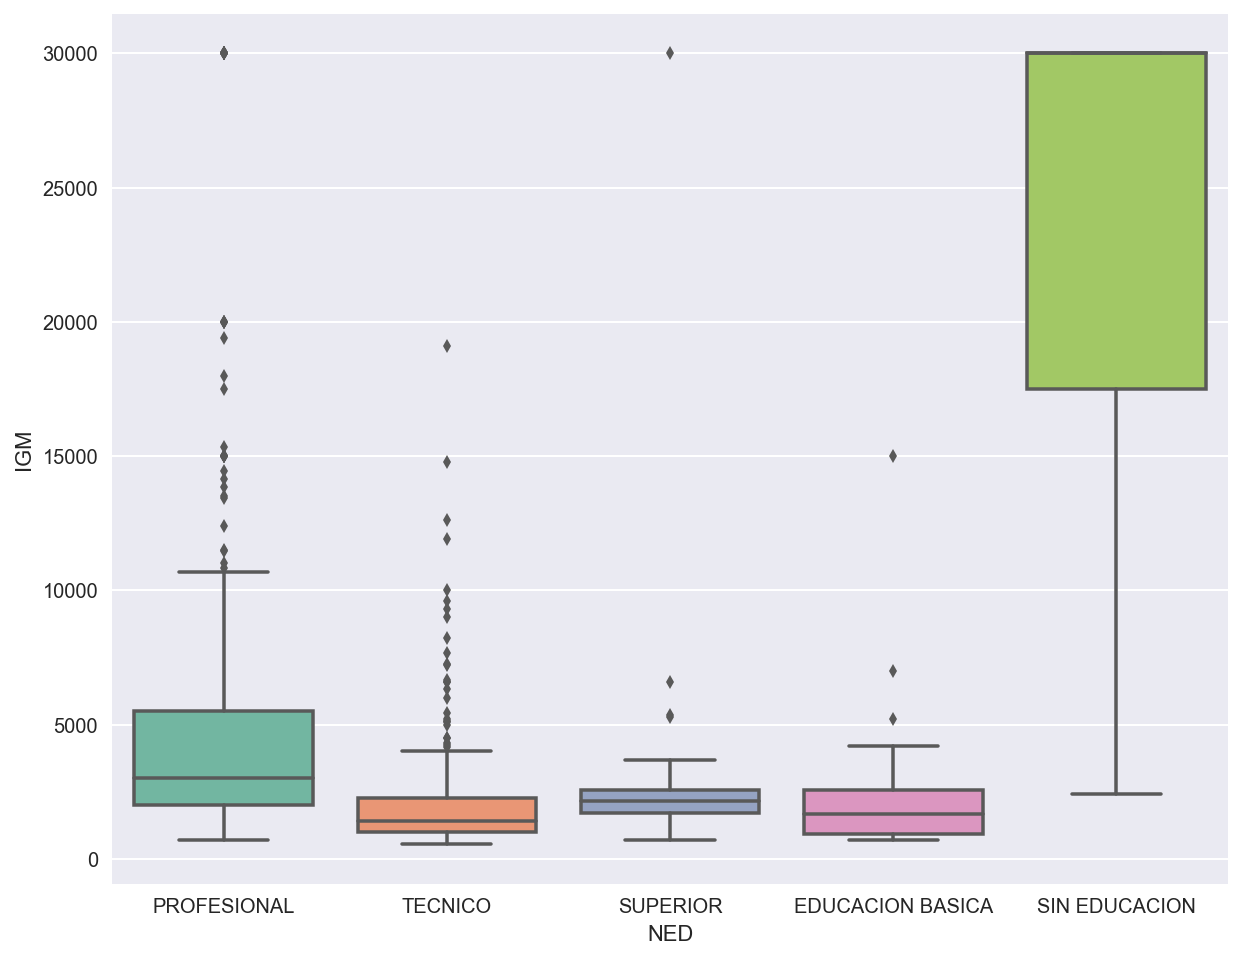

In [786]:
f, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=riesgo, x='NED', y='IGM', palette="Set2");

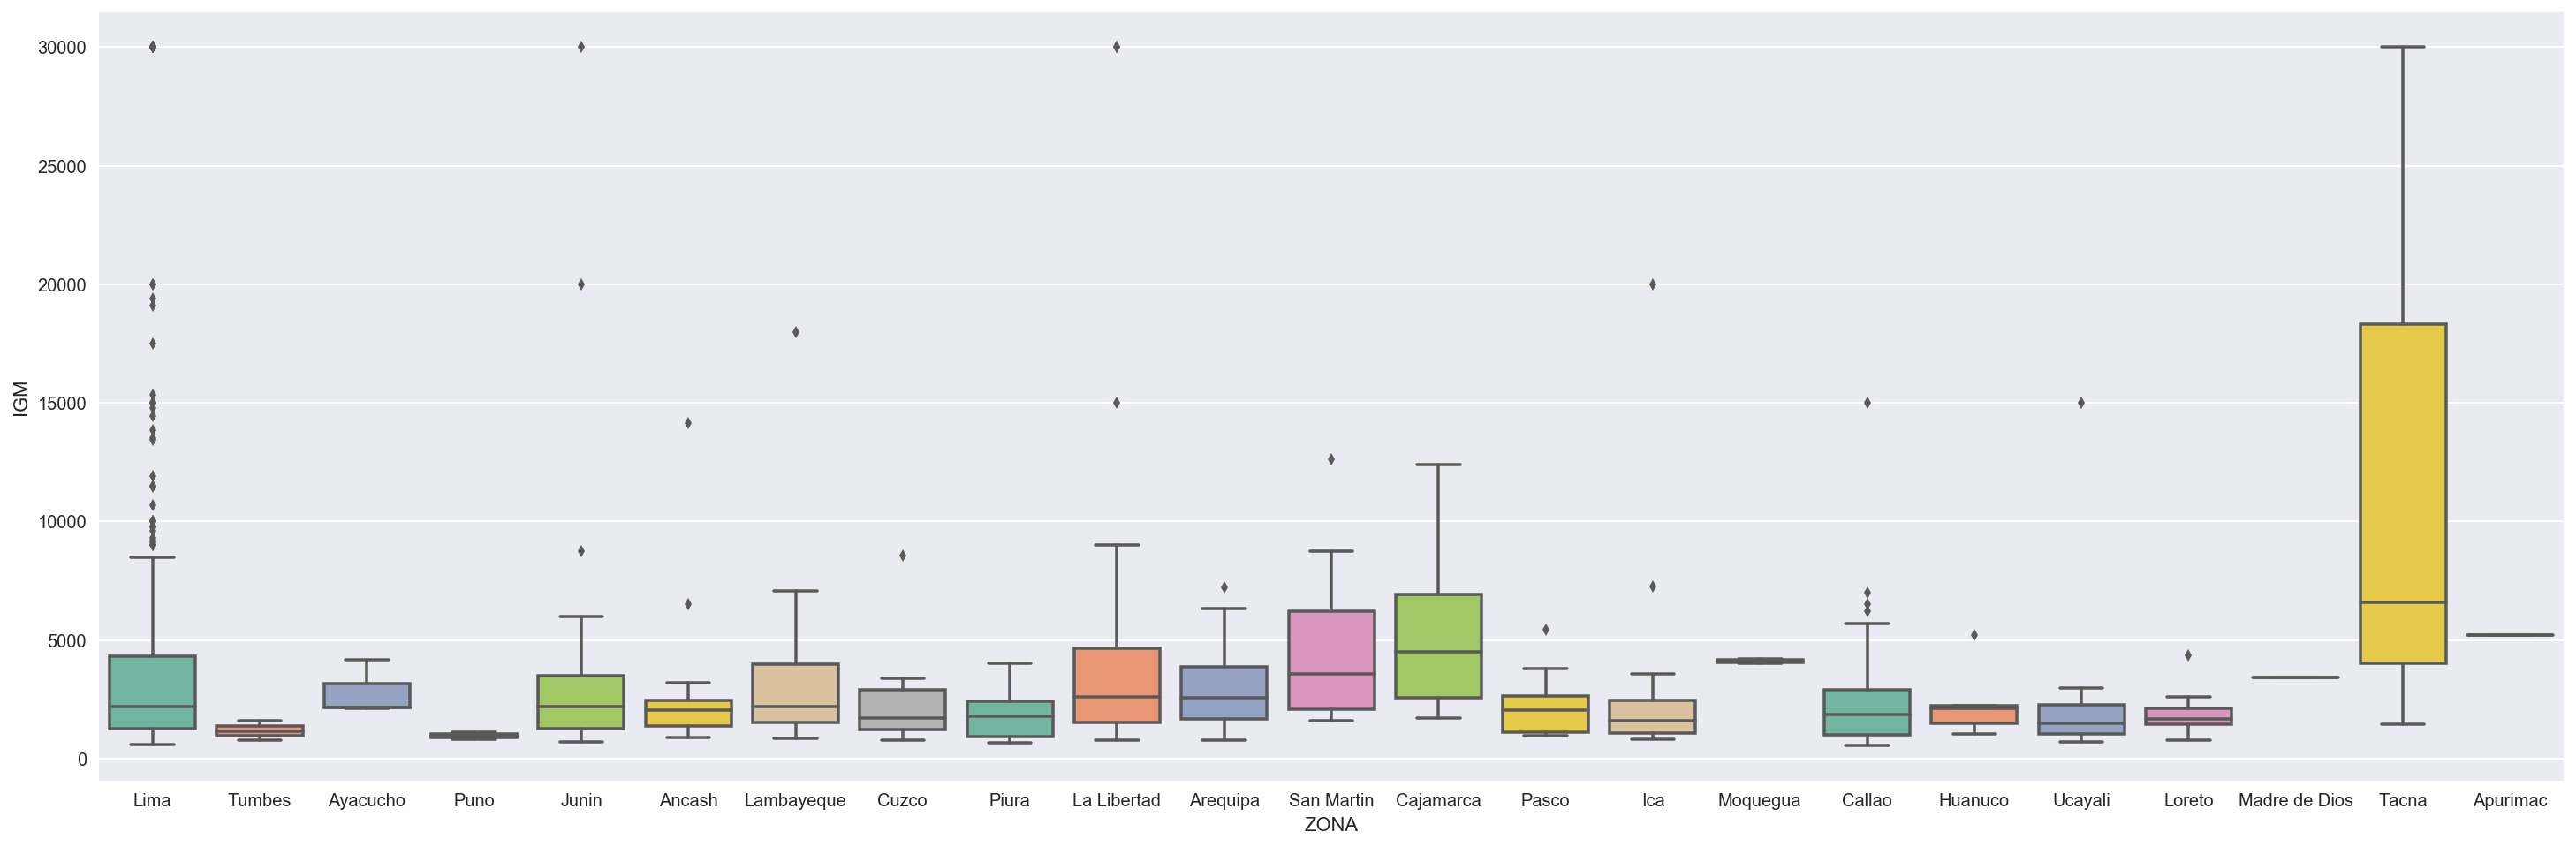

In [770]:
f, ax = plt.subplots(figsize=(25,8))
sns.boxplot(data=riesgo, x='ZONA', y='IGM', palette="Set2");

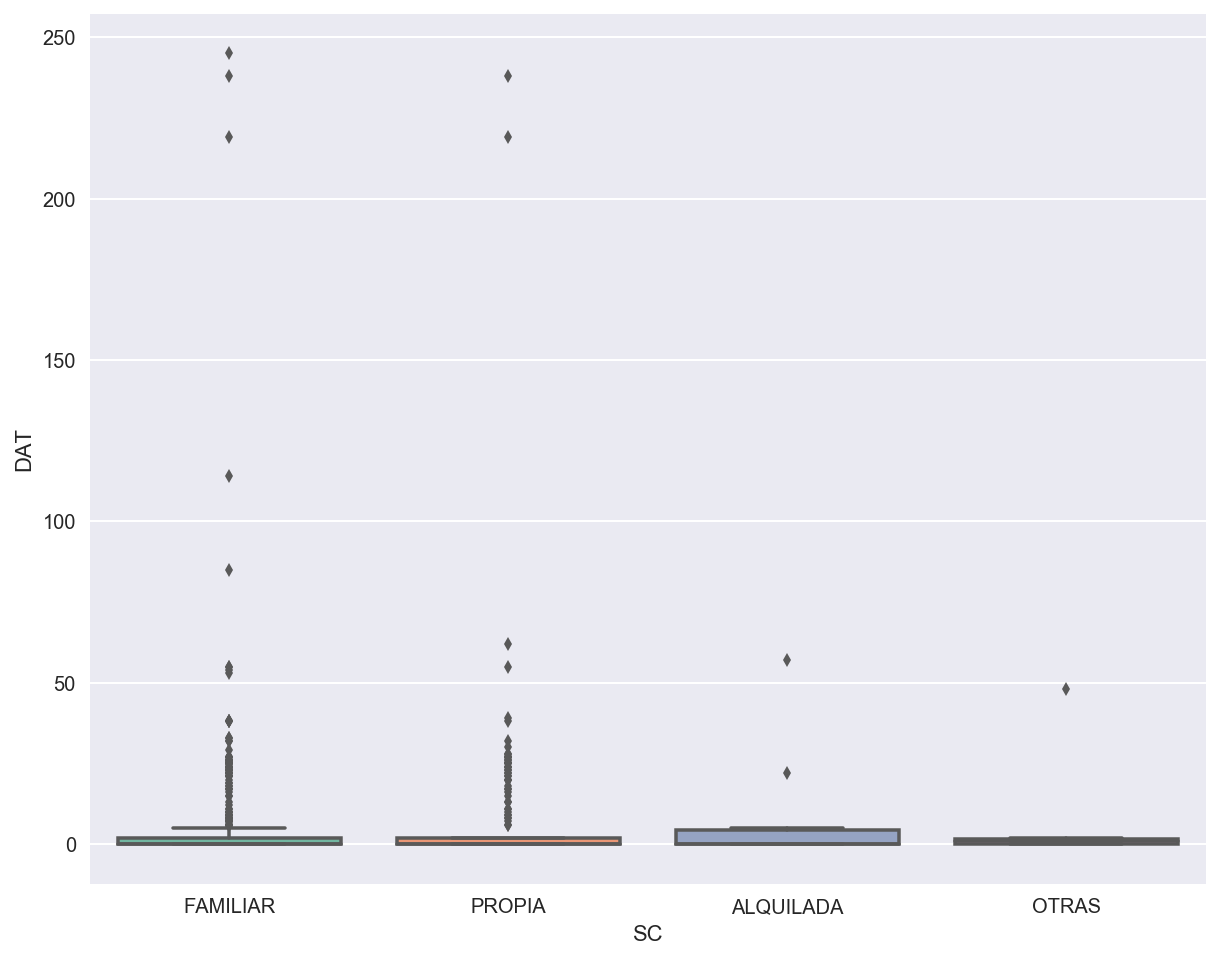

In [760]:
f, ax = plt.subplots(figsize=(10,8))}
sns.boxplot(data=riesgo, x='SC', y='DAT', palette="Set2");

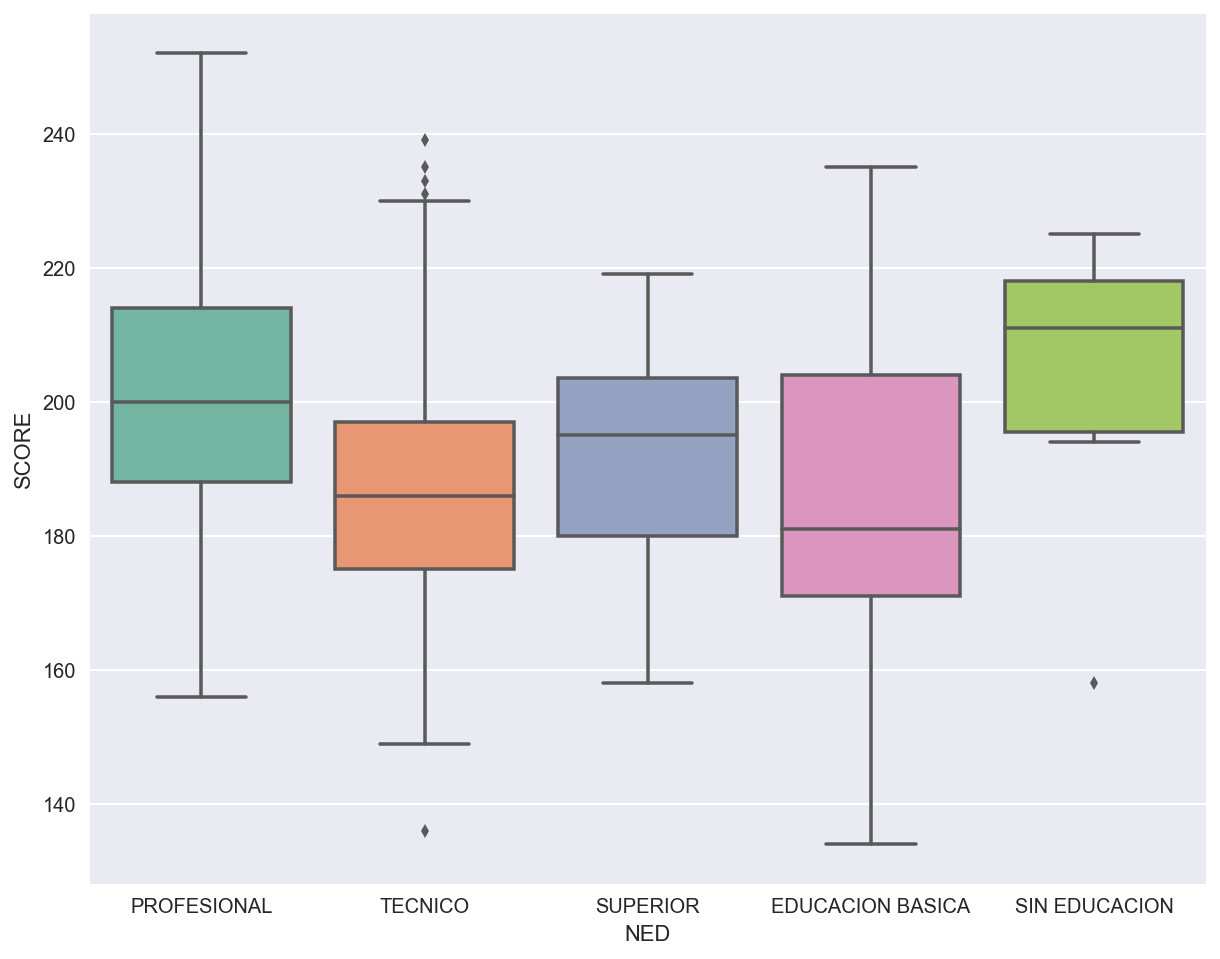

In [781]:
f, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=riesgo, x='NED', y='SCORE', palette="Set2");

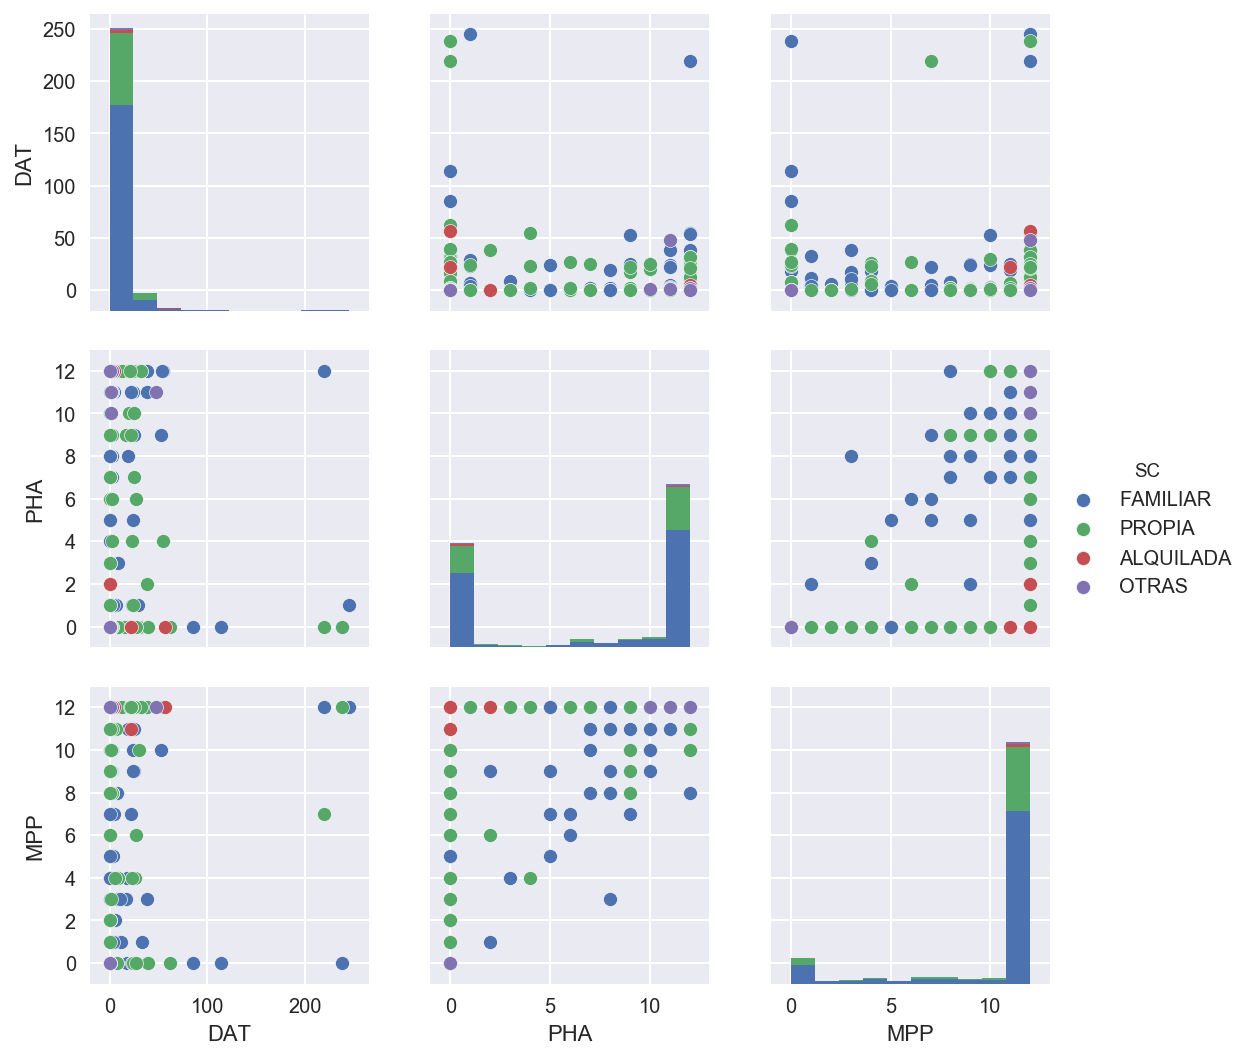

In [778]:
sns.pairplot(riesgo[['DAT', 'PHA', 'MPP', 'SC']], hue='SC');

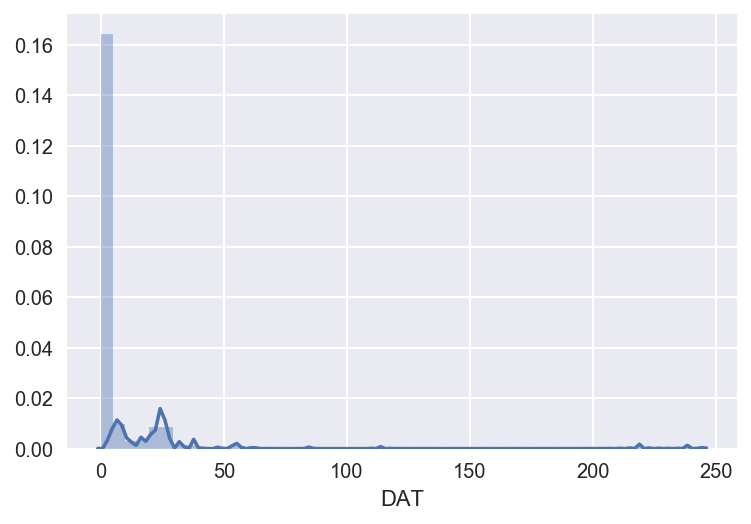

In [792]:
sns.distplot(riesgo['DAT']);

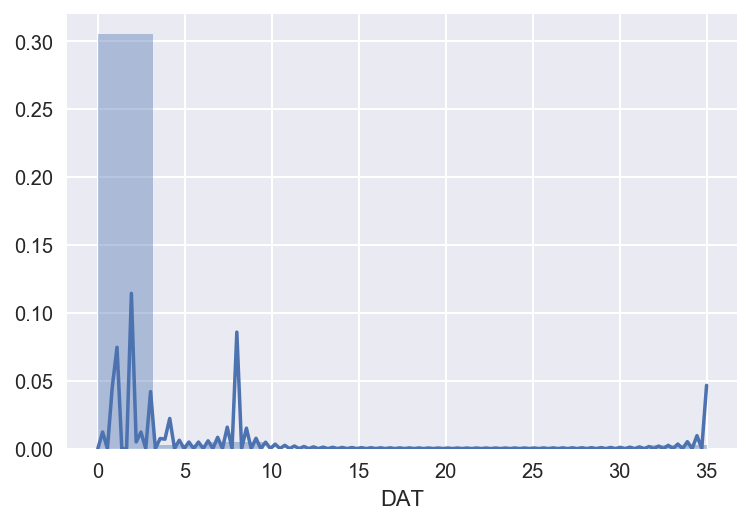

In [791]:
sns.distplot(no_riesgo['DAT']);

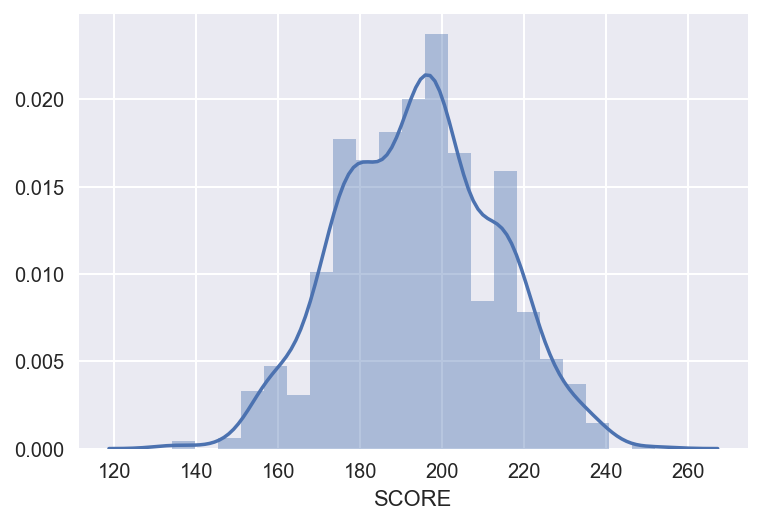

In [790]:
sns.distplot(riesgo['SCORE']);